# **0.1 Imports**

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display       import Image
from matplotlib            import rcParams
import matplotlib.pyplot   as plt

import scipy.stats             as ss
from scipy.stats               import chi2_contingency 
import statsmodels.api         as sm
from category_encoders         import TargetEncoder
from fast_ml.model_development import train_valid_test_split
from sklearn.metrics           import mean_absolute_error, mean_squared_error,make_scorer, mean_absolute_percentage_error
from sklearn.model_selection   import cross_val_predict, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing     import RobustScaler,MinMaxScaler,LabelEncoder
from sklearn.linear_model      import LinearRegression, Lasso
from sklearn.cluster           import AgglomerativeClustering, KMeans
from sklearn.ensemble          import RandomForestRegressor,RandomForestClassifier
from sklearn                   import mixture       as mx
from sklearn                   import ensemble         as en
from sklearn.feature_extraction.text import CountVectorizer
from xgboost                   import XGBRegressor
from catboost                  import CatBoostRegressor
import optuna
import pickle

## **0.1.1 Helper functions**

In [168]:
def mean_absolute_percentage_error_func(y, yhat):
    mask = y != 0
    return np.mean(np.abs(np.where(mask, (y - yhat) / y, 0)))

def mae_scorer(y_true, y_pred):
    return -mean_absolute_error(y_true, y_pred)  # Negativo porque cross_val_score espera escores mais altos

def mape_scorer(y_true, y_pred):
    return -np.mean(np.abs((y_true - y_pred) / y_true))

def mape_scorer(y_true, y_pred):
    mask = y_true != 0  # Cria uma máscara para evitar divisão por zero
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    if len(y_true_masked) == 0:
        # Caso não haja valores diferentes de zero, retorne 0 (ou outro valor apropriado)
        return 0.0

    return -np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked))

def rmse_scorer(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_cramers_v_matrix(dataframe):
    cols = dataframe.columns
    cramers_v_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for i in range(len(cols)):
        for j in range(len(cols)):
            if i == j:
                cramers_v_matrix.iloc[i, j] = 1.0
            else:
                cramers_v = calculate_cramers_v(dataframe[cols[i]], dataframe[cols[j]])
                cramers_v_matrix.iloc[i, j] = cramers_v
                cramers_v_matrix.iloc[j, i] = cramers_v

    return cramers_v_matrix

def calculate_cramers_v(var1, var2):
    contingency_table = pd.crosstab(var1, var2)
    
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def count_words (list):
    # Crie um objeto CountVectorizer
    vectorizer = CountVectorizer()
    
    # Ajuste e transforme os dados 'nome' usando o vetorizador
    X = vectorizer.fit_transform(list['nome'])
    
    # Obtenha os nomes das features (palavras)
    feature_names = vectorizer.get_feature_names_out()
    
    # Crie um DataFrame com as palavras e suas contagens
    word_counts = pd.DataFrame({
        'palavra': feature_names,
        'contagem': X.toarray().sum(axis=0)
    })
    
    # Ordene o DataFrame pelas contagens em ordem decrescente
    word_counts = word_counts.sort_values('contagem', ascending=False)
    
    return word_counts

def categorize_listing(row):
    if row['bairro_group'] == 'Manhattan' and row['room_type'] == 'Entire home/apt' and any(keyword in row['nome'] for keyword in high_price):
        return 'classy'
    elif row['bairro_group'] in ['Queens', 'Bronx'] and row['room_type'] in ['Private room', 'Shared room'] and any(keyword in row['nome'] for keyword in low_price):
        return 'simple'
    else:
        return 'normal'


def haversine_distance(df, lat_d, lon_d):
    lat_p, lon_p = df['latitude'], df['longitude']
    radius = 6371 # km

    dlat = np.radians(lat_d - lat_p)
    dlon = np.radians(lon_d - lon_p)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat_p)) * np.cos(np.radians(lat_d)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = radius * c

    return distance

def mean_percentage_error(y,yhat):
    return np.mean((y-yhat)/y)

def filter_mean(df,bairro_group,bairro,room_type):
    filter = (df['bairro_group'] == bairro_group) & (df['bairro'] == bairro) & (df['room_type'] == room_type)
    aux = df[filter]

    # Calculando a média de preço
    mean = aux['price'].mean()
    return round(mean)

## **0.1.2 Loading data**

In [169]:
df_raw=pd.read_csv('../datasets/raw.csv')

df_raw.head(5)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


# **1 Data description**

## **1.1 Dimensions**

In [170]:
df1=df_raw.copy()

In [171]:
print(f'Number of rows:{df1.shape[0]}')
print(f'Number of cols:{df1.shape[1]}')

Number of rows:48894
Number of cols:16


## **1.2 Data types**

In [172]:
df1.dtypes

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

### **1.2.2 Change types**

In [173]:
df1['ultima_review'] = pd.to_datetime(df1['ultima_review'])
df1['ultima_review'].dtype

dtype('<M8[ns]')

## **1.3 Check na**

In [174]:
df1.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

## **1.4 Fillout/delete na**

In [175]:
# ultima_review/reviews_por_mes
aux=df1[df1['numero_de_reviews']==0]

print(len(aux))

print(aux['ultima_review'].isna().sum())
print(aux['reviews_por_mes'].isna().sum())

aux['reviews_por_mes'].unique()

# se não há reviews, ultima_review e reviews_por_mes são vazios

10052
10052
10052


array([nan])

In [176]:
# substituir todos os NA de reviews_por_mes por 0

df1['reviews_por_mes'] = np.where(df1['reviews_por_mes'].isna(), 0, df1['reviews_por_mes'])
print(df1['reviews_por_mes'].isna().sum())
print(df1['reviews_por_mes'].min())

0
0.0


In [177]:
# ultima_review será mantida com os nans por enquanto

In [178]:
# substituir as linhas com nans em nome e host_name por 'desconhecido'

cols = ['nome','host_name']
df1[cols] = np.where(df1[cols].isna(), 'desconhecido', df1[cols])

print(df1['nome'].isna().sum())
print(df1['host_name'].isna().sum())

0
0


## **1.5 Descriptive statistics**

### **1.5.1 Numeric**

In [179]:
desc = df1.describe().T.reset_index()
desc.columns = ['attributes', 'count', 'mean', 'min', '25%', '50%', '75%', 'max', 'std']

desc

,attributes,count,mean,min,25%,50%,75%,max,std
0,id,48894.0,19017532.130609,2595.0,9472370.75,19677431.5,29152249.25,36487245.0,10982884.048876
1,host_id,48894.0,67621393.581605,2438.0,7822736.75,30795529.0,107434423.0,274321313.0,78611176.150486
2,latitude,48894.0,40.728951,40.49979,40.6901,40.723075,40.763117,40.91306,0.054529
3,longitude,48894.0,-73.952169,-74.24442,-73.98307,-73.95568,-73.936273,-73.71299,0.046157
4,price,48894.0,152.720763,0.0,69.0,106.0,175.0,10000.0,240.156625
5,minimo_noites,48894.0,7.030085,1.0,1.0,3.0,5.0,1250.0,20.510741
6,numero_de_reviews,48894.0,23.274758,0.0,1.0,5.0,24.0,629.0,44.550991
7,ultima_review,38842,2018-10-04 01:46:50.710055936,2011-03-28 00:00:00,2018-07-08 00:00:00,2019-05-19 00:00:00,2019-06-23 00:00:00,2019-07-08 00:00:00,NaN
8,reviews_por_mes,48894.0,1.090928,0.0,0.04,0.37,1.58,58.5,1.597294
9,calculado_host_listings_count,48894.0,7.144005,1.0,1.0,1.0,2.0,327.0,32.952855


### **1.5.2 Categorical**

In [180]:
colunas = ['nome', 'host_name', 'bairro_group', 'bairro', 'room_type']

for coluna in colunas:
    print(f"{coluna.capitalize()}s únicos: {len(df1[coluna].unique())}")

Nomes únicos: 47905
Host_names únicos: 11453
Bairro_groups únicos: 5
Bairros únicos: 221
Room_types únicos: 3


# **2 Feature engineering**

In [181]:
df2=df1.copy()

## **Train, validation, test separation**

In [182]:
x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test_split(df2, 
                                                        target = 'price', 
                                                        train_size=0.8, valid_size=0.1, test_size=0.1,
                                                        random_state=42)

df2=pd.concat ([x_train, y_train], axis=1).reset_index(drop=True) 
# df2=df2[df2['price']>0] 

# print(len(df2))
# print(len(x_train))
# print(len(x_val))
# print(len(x_test))
# print(len(y_train))
# print(len(y_val))
# print(len(y_test))

# change types
x_val['ultima_review'] = pd.to_datetime(x_val['ultima_review'])
x_test['ultima_review'] = pd.to_datetime(x_test['ultima_review'])

# nas
x_val['reviews_por_mes'] = np.where(x_val['reviews_por_mes'].isna(), 0, x_val['reviews_por_mes'])
x_test['reviews_por_mes'] = np.where(x_test['reviews_por_mes'].isna(), 0, x_test['reviews_por_mes'])

cols = ['nome','host_name']
x_val[cols] = np.where(x_val[cols].isna(), 'desconhecido', x_val[cols])
x_test[cols] = np.where(x_test[cols].isna(), 'desconhecido', x_test[cols])

## **category**

In [183]:
# lista final de palavras divididas em duas categorias

high_price = ['townhouse', 'luxury','hidde2','penthouse', 'chelsea', 'superbowl',
                     'suite', 'soho', 'duplex', 'events', 'tribeca', 'film',
                     'service', 'tower', 'beekman', '3br', 'terrace']

low_price=['1br','harlem','br' , 'near','bushwick', 'harlem','close', 'subway', 
       'train','bushwick', 'shared', 'subway', 'train', 'close', 'jfk',
       'heights', 'comfortable', 'lga', 'queens']

# criando a feature com uma função que reune todas as condições
df2['category'] = df2.apply(categorize_listing, axis=1)
x_val['category'] = x_val.apply(categorize_listing, axis=1)
x_test['category'] = x_test.apply(categorize_listing, axis=1)

## **ultima review**

In [184]:
# preenchendo nans com um dia depois da última data do dataset 
df2['ultima_review'] = df2['ultima_review'].fillna('2019-07-09')
x_val['ultima_review'] = x_val['ultima_review'].fillna('2019-07-09')
x_test['ultima_review'] = x_test['ultima_review'].fillna('2019-07-09')

# calculando a diferença de dias desde o dia mais recente até a última review
ref_date = pd.to_datetime('2019-07-09')
df2['ultima_review'] = (df2['ultima_review'] - ref_date).dt.days * -1
x_val['ultima_review'] = (x_val['ultima_review'] - ref_date).dt.days * -1
x_test['ultima_review'] = (x_test['ultima_review'] - ref_date).dt.days * -1

# **3 Variable filtering**

In [185]:
df3=df2.copy()

In [186]:
# tirar outliers do price

df3[['price','bairro_group','room_type']].sort_values('price',ascending=False).head(50)

,price,bairro_group,room_type
7477,10000,Queens,Private room
18448,10000,Brooklyn,Entire home/apt
12442,10000,Manhattan,Entire home/apt
22269,9999,Manhattan,Entire home/apt
19411,8500,Manhattan,Entire home/apt
8605,8000,Brooklyn,Entire home/apt
31581,7703,Manhattan,Entire home/apt
25182,7500,Manhattan,Entire home/apt
34924,7500,Brooklyn,Private room
19172,6800,Manhattan,Entire home/apt


In [187]:
print(len(df3[df3['price']<=100]))
print(len(df3[(df3['price']>100)  & (df3['price'] <=300)]))
print(len(df3[(df3['price']>300)  & (df3['price'] <=500)]))
print(len(df3[(df3['price']>500)  & (df3['price'] <=700)]))
print(len(df3[(df3['price']>700)  & (df3['price'] <=900)]))
print(len(df3[(df3['price']>900)  & (df3['price'] <=1100)]))
print(len(df3[(df3['price']>900)  & (df3['price'] <=1100)]))

19129
17260
1868
373
191
109
109


In [188]:
df3=df3[df3['price']<5000]

In [189]:
# # substituir os preços igual a zero pela média baseada nas principais características

mean1=filter_mean(df3,'Brooklyn','Bushwick','Shared room')
mean2=filter_mean(df3,'Brooklyn','Williamsburg','Entire home/apt')
mean3=filter_mean(df3,'Brooklyn','Bedford-Stuyvesant','Private room')
mean4=filter_mean(df3,'Bronx','East Morrisania','Private room')
mean5=filter_mean(df3,'Brooklyn','Bedford-Stuyvesant','Private room')
mean6=filter_mean(df3,'Brooklyn','Greenpoint','Private room')
mean7=filter_mean(df3,'Manhattan','Murray Hill','Entire home/apt')

df3['price'] = np.where(df3['id'] == 21291569, mean1, df3['price'])
df3['price'] = np.where(df3['id'] == 20624541, mean2, df3['price'])
df3['price'] = np.where(df3['id'] == 20639914, mean3, df3['price'])
df3['price'] = np.where(df3['id'] == 20333471, mean4, df3['price'])
df3['price'] = np.where(df3['id'] == 20639792, mean5, df3['price'])
df3['price'] = np.where(df3['id'] == 20639628, mean5, df3['price'])
df3['price'] = np.where(df3['id'] == 18750597, mean5, df3['price'])
df3['price'] = np.where(df3['id'] == 20608117, mean6, df3['price'])
df3['price'] = np.where(df3['id'] == 20933849, mean7, df3['price'])

# **4 Exploratory data analysis**

In [190]:
df4=df3.copy()

## **4.1 Univariate analysis**

### **4.1.1 Response variable**

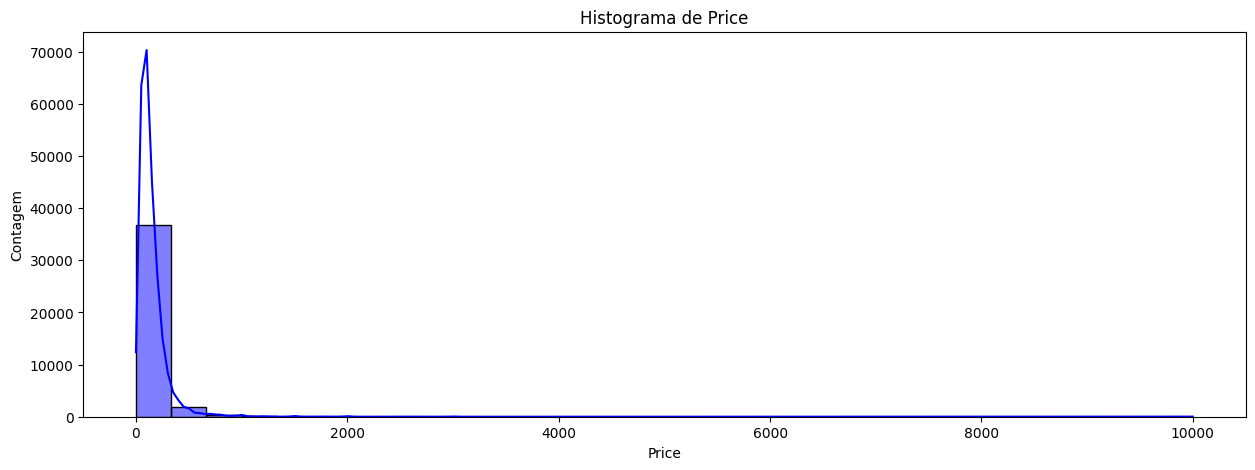

In [21]:
plt.figure(figsize=(15, 5)) 
sns.histplot(df4['price'], bins=30, kde=True, color='blue')
plt.title('Histograma de Price')
plt.xlabel('Price')
plt.ylabel('Contagem')
plt.show()

In [22]:
print(len(df4[df4['price']==0]))
print('\n')
df4[df4['price']==0]

9




,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,price
3449,21291569,Coliving in Brooklyn! Modern design / Shared room,101970559,Sergii,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,30,2,2019-06-22,0.11,6,333,0
5423,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,5,3,2018-01-02,0.15,1,73,0
6263,20639914,Cozy yet spacious private brownstone bedroom,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,1,95,2019-06-23,4.35,6,222,0
15934,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,2,55,2019-06-24,2.56,4,127,0
16030,20639792,Contemporary bedroom in brownstone with nice view,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,1,95,2019-06-21,4.37,6,232,0
17115,20639628,Spacious comfortable master bedroom with nice ...,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,1,93,2019-06-15,4.28,6,176,0
17147,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,4,1,2018-01-06,0.05,4,28,0
31707,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,2,12,2017-10-27,0.53,2,0,0
38671,20933849,the best you can find,13709292,Qiuchi,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,3,0,NaT,0.00,1,0,0


### **4.1.2 Numerical variables**

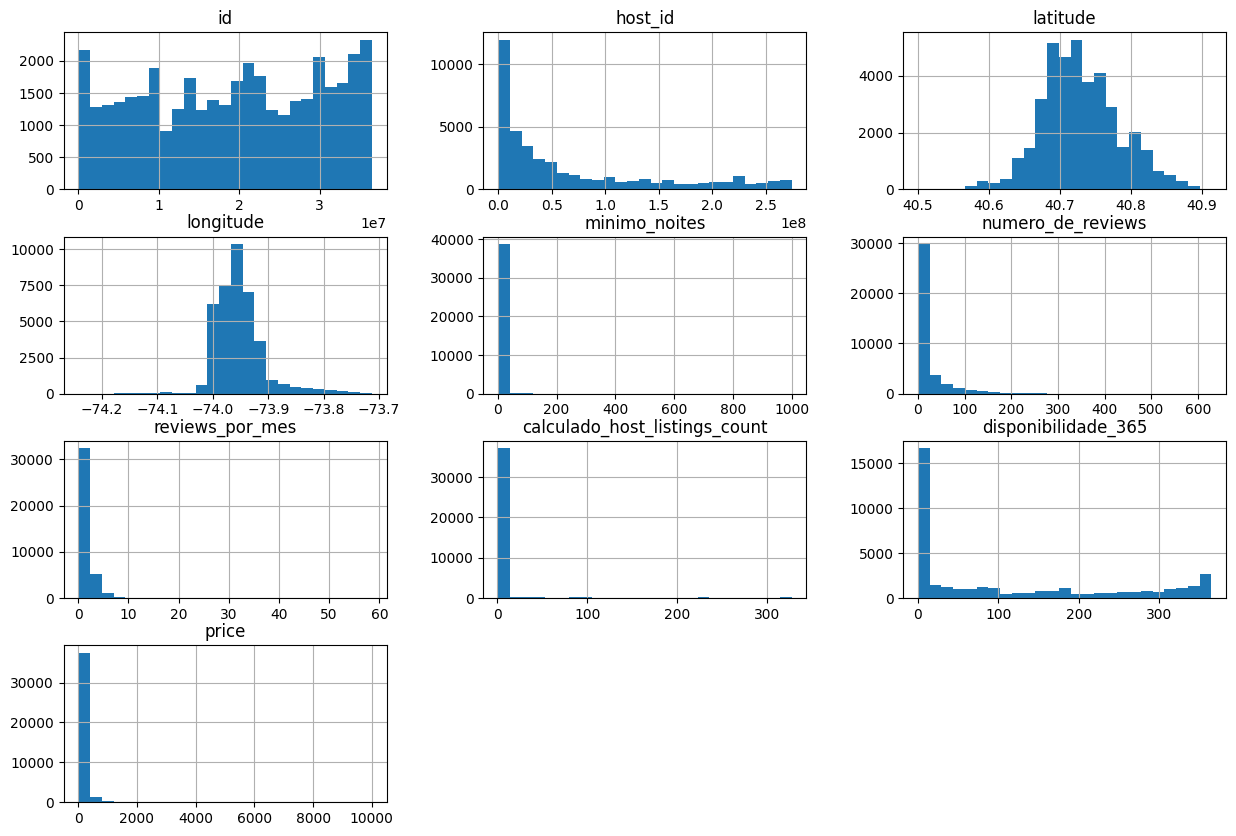

In [23]:
rcParams['figure.figsize'] = 15,10

num_attributes = df4.select_dtypes(include=['int64', 'float64'])
num_attributes.hist(bins=25);

### **4.1.3 Categorical variables**

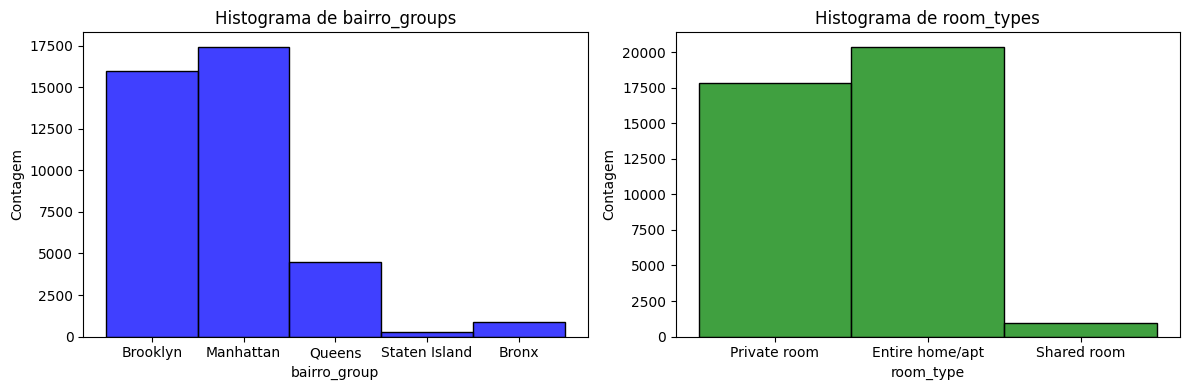

In [24]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(df4['bairro_group'], color='blue', bins=len(df4['bairro_group'].unique()))
plt.title('Histograma de bairro_groups')
plt.xlabel('bairro_group')
plt.ylabel('Contagem')

plt.subplot(1, 2, 2)
sns.histplot(df4['room_type'], color='green', bins=len(df4['room_type'].unique()))
plt.title('Histograma de room_types')
plt.xlabel('room_type')
plt.ylabel('Contagem')

plt.tight_layout()
plt.show()

In [25]:
df4['bairro'].value_counts().head(20)

bairro
Williamsburg          3118
Bedford-Stuyvesant    2974
Harlem                2144
Bushwick              1945
Upper West Side       1592
Hell's Kitchen        1577
East Village          1504
Upper East Side       1442
Midtown               1259
Crown Heights         1250
Greenpoint             906
East Harlem            899
Chelsea                897
Astoria                728
Lower East Side        719
Washington Heights     710
West Village           614
Financial District     595
Flatbush               495
Clinton Hill           443
Name: count, dtype: int64

## **4.2 Hypothesis**

### **4.2.1 Hypothesis mindmap**

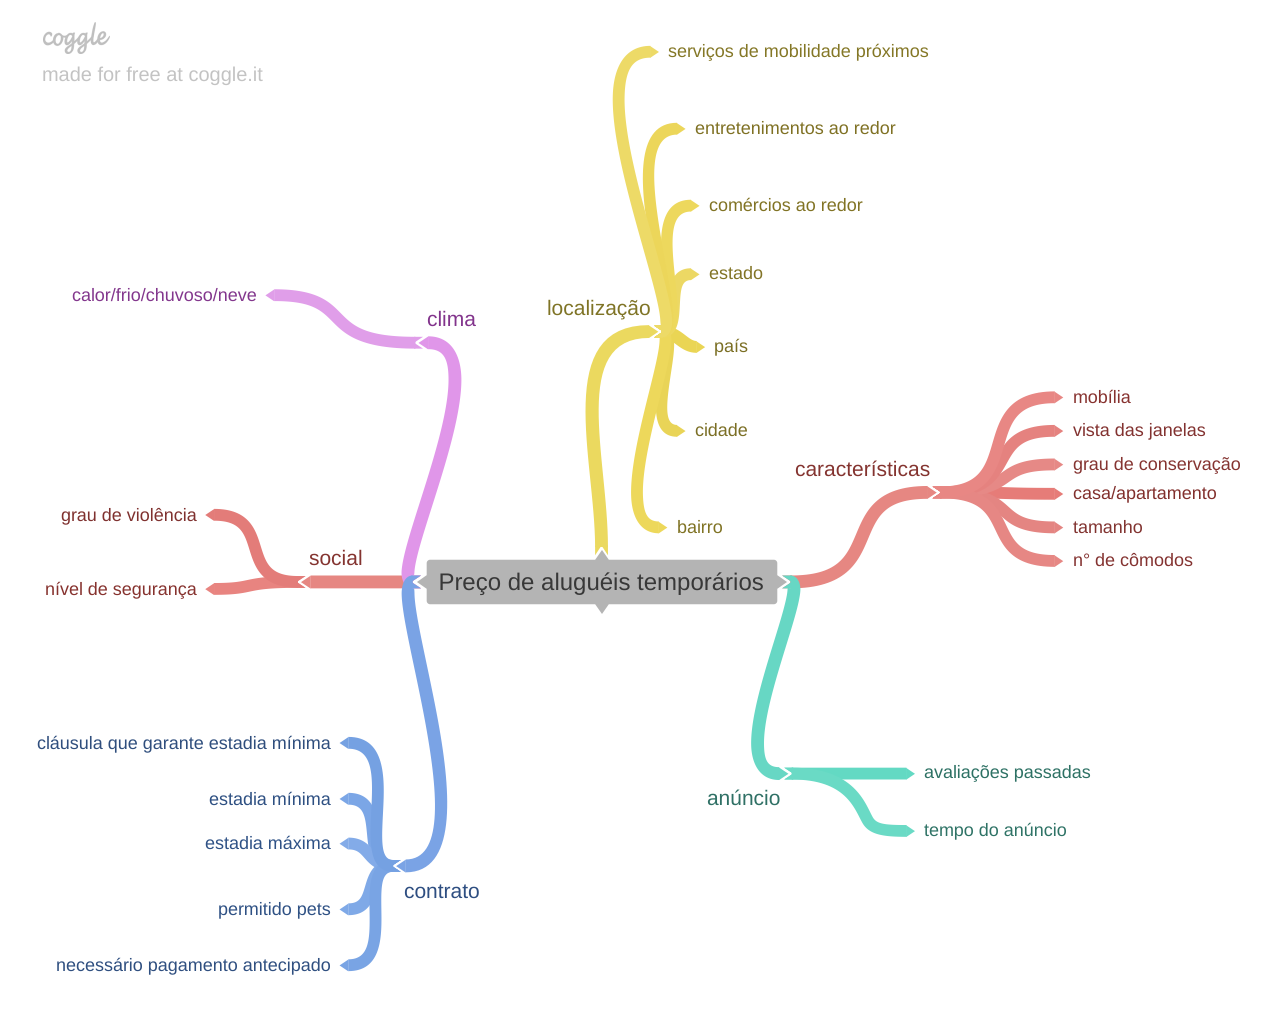

In [26]:
Image('../img/mindmap.png')

### **4.2.2 Hypothesis creation**

#### **H1 - Manhattan tem em média preços pelo menos 30% maiores**
**True**



A diferença percentual da média de Manhattan em relação às outras cidades:

    bairro_group  diff_percent
0      Manhattan      0.000000
1       Brooklyn    -36.960833
2  Staten Island    -41.154268
3         Queens    -49.246618
4          Bronx    -55.863517


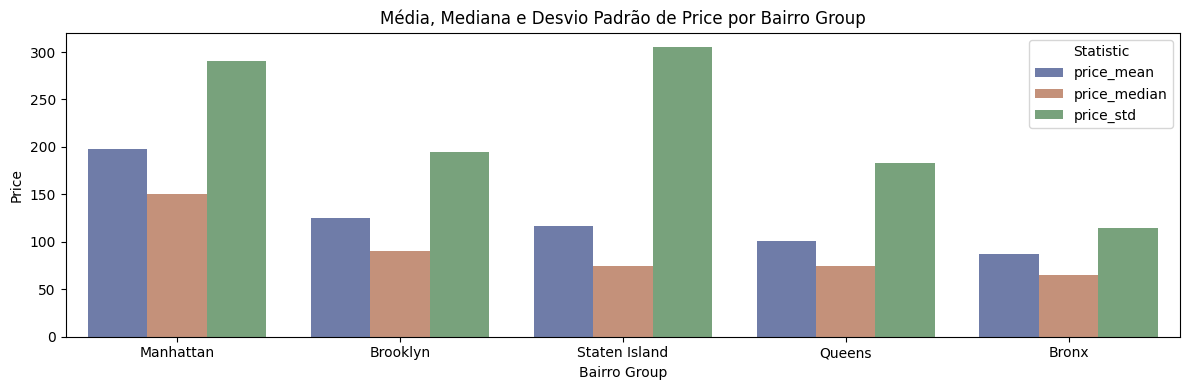

In [27]:
aux1 = df4[['bairro_group', 'price']].groupby('bairro_group').mean().sort_values('price', ascending=False).reset_index()
aux2 = df4[['bairro_group', 'price']].groupby('bairro_group').median().sort_values('price', ascending=False).reset_index()
aux3 = df4[['bairro_group', 'price']].groupby('bairro_group').std().sort_values('price', ascending=False).reset_index()

result1 = pd.merge(aux1, aux2, on='bairro_group', suffixes=('_mean', '_median'))
result2 = pd.merge(result1, aux3, on='bairro_group', suffixes=('', '_std'))
aux = result2.rename(columns={'price': 'price_std'})

viz = pd.melt(aux, id_vars=['bairro_group'], value_vars=['price_mean', 'price_median', 'price_std'],
              var_name='Statistic', value_name='Value')

plt.figure(figsize=(12, 4))
ax = sns.barplot(
    data=viz, x="bairro_group", y="Value", hue="Statistic",
    errorbar="sd", palette="dark", alpha=.6)

ax.set_title('Média, Mediana e Desvio Padrão de Price por Bairro Group')
ax.set_xlabel('Bairro Group')
ax.set_ylabel('Price')

plt.tight_layout()

city = 'Manhattan'
manhattan_mean = aux.loc[aux['bairro_group'] == city, 'price_mean'].values[0]
aux['diff_percent'] = ((aux['price_mean'] - manhattan_mean) / manhattan_mean) * 100

print('\n')
print(f"A diferença percentual da média de {city} em relação às outras cidades:\n")
print(aux[['bairro_group', 'diff_percent']])

#### **H2 - Room type do tipo 'Entire home/apt' são pelo menos 100% mais caros em média**
**False**



A diferença percentual da média de Entire home/apt em relação aos outros room types:

         room_type  diff_percent
0  Entire home/apt      0.000000
1     Private room    -57.721551
2      Shared room    -67.199822


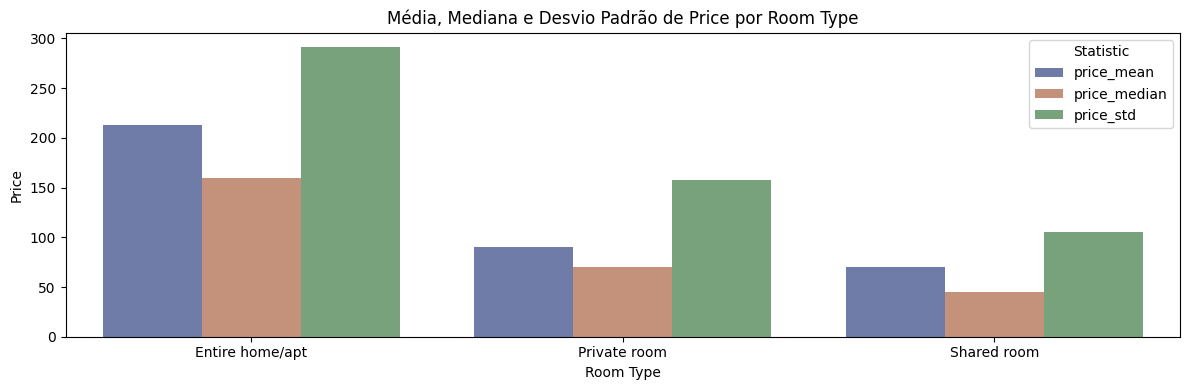

In [28]:
aux1 = df4[['room_type', 'price']].groupby('room_type').mean().sort_values('price', ascending=False).reset_index()
aux2 = df4[['room_type', 'price']].groupby('room_type').median().sort_values('price', ascending=False).reset_index()
aux3 = df4[['room_type', 'price']].groupby('room_type').std().sort_values('price', ascending=False).reset_index()

result1 = pd.merge(aux1, aux2, on='room_type', suffixes=('_mean', '_median'))
result2 = pd.merge(result1, aux3, on='room_type', suffixes=('', '_std'))
aux = result2.rename(columns={'price': 'price_std'})

viz = pd.melt(aux, id_vars=['room_type'], value_vars=['price_mean', 'price_median', 'price_std'],
              var_name='Statistic', value_name='Value')

plt.figure(figsize=(12, 4))
sns.barplot(
    data=viz, x="room_type", y="Value", hue="Statistic",
    errorbar="sd", palette="dark", alpha=.6)

plt.title('Média, Mediana e Desvio Padrão de Price por Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.legend(title='Statistic')

plt.tight_layout()

room = 'Entire home/apt'
room_mean = aux.loc[aux['room_type'] == room, 'price_mean'].values[0]
aux['diff_percent'] = ((aux['price_mean'] - room_mean) / room_mean) * 100

print('\n')
print(f"A diferença percentual da média de {room} em relação aos outros room types:\n")
print(aux[['room_type', 'diff_percent']])

#### **H3 Aluguéis disponíveis por no máximo uma semana são pelo menos 30% mais caros em média**

In [29]:
aux=df4[['minimo_noites','price']].groupby('minimo_noites').mean().sort_values('price',ascending=False).reset_index()

# check outliers
aux.sort_values('price',ascending=False).head(10)

,minimo_noites,price
0,114,4200.000000
1,100,1141.500000
2,40,464.833333
3,1000,400.000000
4,70,395.750000
5,365,388.434783
6,175,350.000000
7,198,346.000000
8,23,320.000000
9,80,269.285714




A média do preço para minimo_noites até 7 é: 154.76
A média do preço para minimo_noites maior que 7 é: 147.16
A diferença percentual é: -5.17%


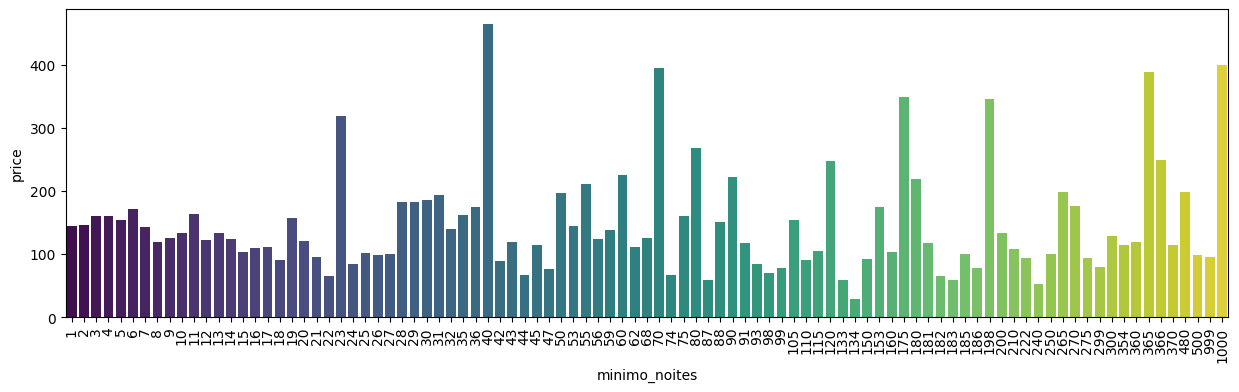

In [30]:
aux=aux[aux['price']<1000]

plt.figure(figsize=(15, 4))
sns.barplot(data=aux, x='minimo_noites', y='price', ci='sd', palette='viridis')
plt.xticks(rotation=90)

condicao = aux['minimo_noites'] <= 7

media_menor_7 = aux.loc[condicao, 'price'].mean()
media_maior_7 = aux.loc[~condicao, 'price'].mean()

diff_percent = ((media_maior_7 - media_menor_7) / media_maior_7) * 100

print('\n')
print(f"A média do preço para minimo_noites até 7 é: {media_menor_7:.2f}")
print(f"A média do preço para minimo_noites maior que 7 é: {media_maior_7:.2f}")
print(f"A diferença percentual é: {diff_percent:.2f}%")

#### **H4 ?**

## **4.3 Bivariate analysis**

### **id**

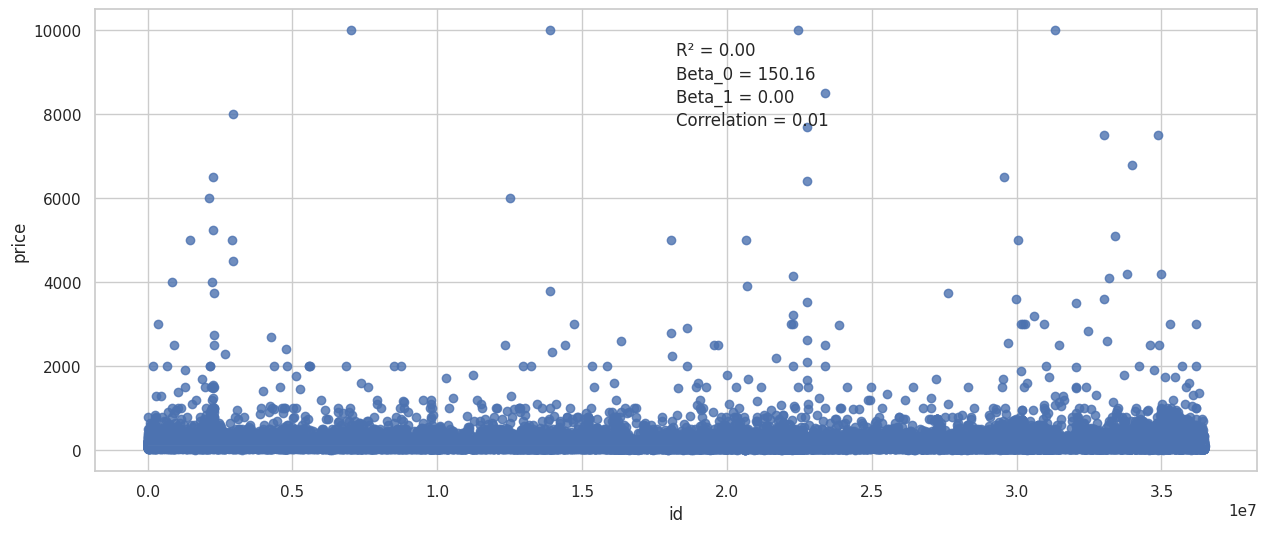

In [31]:
X = sm.add_constant(df4['id'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['id'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='id', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='id', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **nome**

In [32]:
print(len(df4))
print(len(df4['nome'].unique()))

39115
38444


In [33]:
aux=df4[['nome','price']].groupby('nome').mean().sort_values('price',ascending=False).reset_index().head(50)
aux

,nome,price
0,Furnished room in Astoria apartment,10000.0
1,1-BR Lincoln Center,10000.0
2,Luxury 1 bedroom apt. -stunning Manhattan views,10000.0
3,2br - The Heart of NYC: Manhattans Lower East ...,9999.0
4,Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho,8500.0
5,Film Location,8000.0
6,East 72nd Townhouse by (Hidden by Airbnb),7703.0
7,Gem of east Flatbush,7500.0
8,70' Luxury MotorYacht on the Hudson,7500.0
9,3000 sq ft daylight photo studio,6800.0


In [34]:
aux=df4[['nome','price']].groupby('nome').mean().sort_values('price',ascending=True).reset_index().head(50)
aux

,nome,price
0,Coliving in Brooklyn! Modern design / Shared room,0.0
1,★Hostel Style Room | Ideal Traveling Buddies★,0.0
2,Cozy yet spacious private brownstone bedroom,0.0
3,Contemporary bedroom in brownstone with nice view,0.0
4,"Sunny, Quiet Room in Greenpoint",0.0
5,Modern apartment in the heart of Williamsburg,0.0
6,"Huge Brooklyn Brownstone Living, Close to it all.",0.0
7,the best you can find,0.0
8,Spacious comfortable master bedroom with nice ...,0.0
9,Jen Apt,10.0


### **host_name**

In [35]:
print(len(df4))
print(len(df4['host_name'].unique()))

39115
10029


In [36]:
# aux=df4[['host_name','price']].groupby('host_name').mean().sort_values('price',ascending=False).reset_index().head(20)
aux = (df4[['host_name', 'price']].groupby('host_name')
                                  .agg({'price': ['mean', 'count']})
                                  .sort_values(('price', 'mean'), ascending=False)
                                  .reset_index().head(20))
aux

host_name   price      
                       mean count
0               Rum  8500.0     1
1       Jay And Liz  6000.0     1
2          Kathrine  5158.0     2
3           Sarah-2  5000.0     1
4              Nony  4200.0     1
5            Jelena  3400.0     3
6   Luxury Property  3000.0     1
7           Rogelio  2999.0     1
8          Viberlyn  2995.0     1
9   Ilo And Richard  2990.0     1
10            Lanie  2900.0     1
11             Shah  2600.0     1
12             Indi  2400.0     1
13            Iveta  2350.0     1
14              Ege  2000.0     1
15      Mary Rotsen  1999.0     1
16     Ben And Jess  1899.0     1
17            Romeo  1799.0     1
18            NuAve  1750.0     1
19             Ilsa  1750.0     1

In [37]:
aux = (df4[['host_name', 'price']].groupby('host_name')
                                  .agg({'price': ['mean', 'count']})
                                  .sort_values(('price', 'mean'), ascending=True)
                                  .reset_index().head(20))
aux

host_name price      
                          mean count
0                Aymeric   0.0     1
1                 Qiuchi   0.0     1
2      Vishanti & Jeremy  10.0     1
3                  Salim  10.0     1
4               Carolann  12.0     1
5                 Kevin4  18.0     2
6                   Imoy  19.5     2
7            Rimma & Jim  20.0     1
8               Elisheva  20.0     1
9           Ben And Jane  20.0     1
10             Kartikeya  20.0     1
11                Satish  22.0     1
12               Jesus A  22.0     1
13  Christine & Einstein  22.0     1
14                 Zafir  23.0     1
15                   Ysa  24.0     1
16            LKL Rental  24.0     3
17                Kelcie  24.0     1
18                Kadeen  25.0     1
19                Obinna  25.0     1

### **bairro_group**

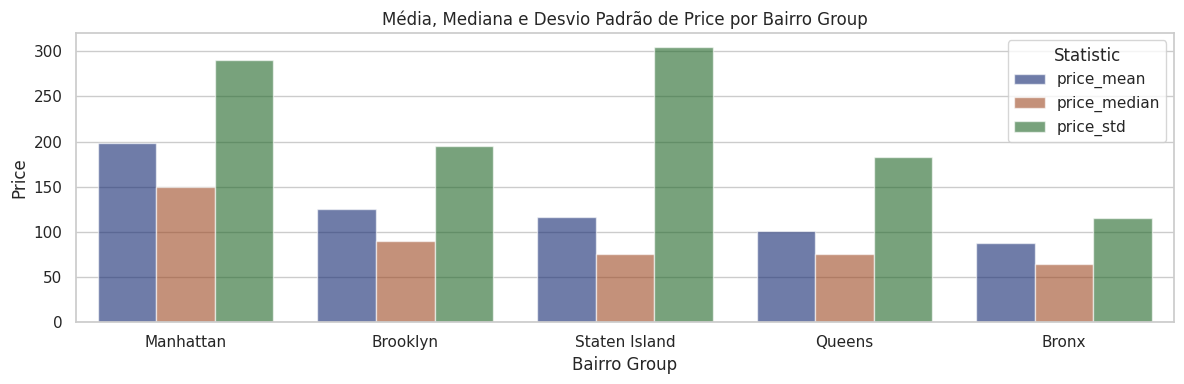

In [38]:
aux1 = df4[['bairro_group', 'price']].groupby('bairro_group').mean().sort_values('price', ascending=False).reset_index()
aux2 = df4[['bairro_group', 'price']].groupby('bairro_group').median().sort_values('price', ascending=False).reset_index()
aux3 = df4[['bairro_group', 'price']].groupby('bairro_group').std().sort_values('price', ascending=False).reset_index()

result1 = pd.merge(aux1, aux2, on='bairro_group', suffixes=('_mean', '_median'))
result2 = pd.merge(result1, aux3, on='bairro_group', suffixes=('', '_std'))
aux = result2.rename(columns={'price': 'price_std'})

viz = pd.melt(aux, id_vars=['bairro_group'], value_vars=['price_mean', 'price_median', 'price_std'],
              var_name='Statistic', value_name='Value')

plt.figure(figsize=(12, 4))
ax = sns.barplot(
    data=viz, x="bairro_group", y="Value", hue="Statistic",
    errorbar="sd", palette="dark", alpha=.6)

ax.set_title('Média, Mediana e Desvio Padrão de Price por Bairro Group')
ax.set_xlabel('Bairro Group')
ax.set_ylabel('Price')

plt.tight_layout()

### **bairro**

In [39]:
print(len(df4))
print(len(df4['bairro'].unique()))

39115
218


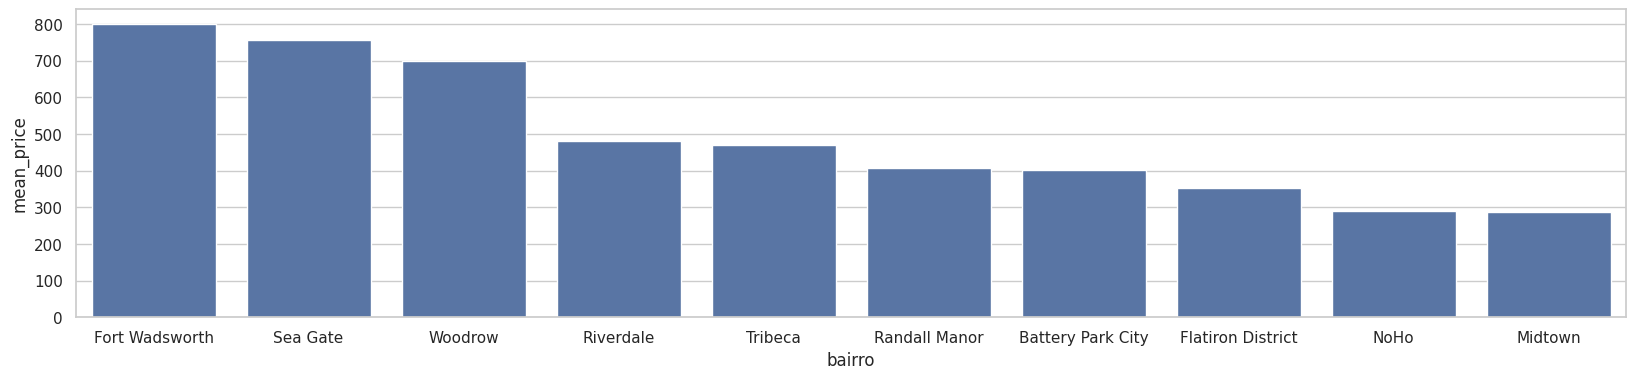

In [40]:
aux1=df4[['bairro','price']].groupby('bairro').mean().sort_values('price',ascending=False).rename(columns={'price':'mean_price'}).reset_index().head(10)
plt.figure(figsize=(20, 4))
sns.barplot(data=aux1,x='bairro',y='mean_price');

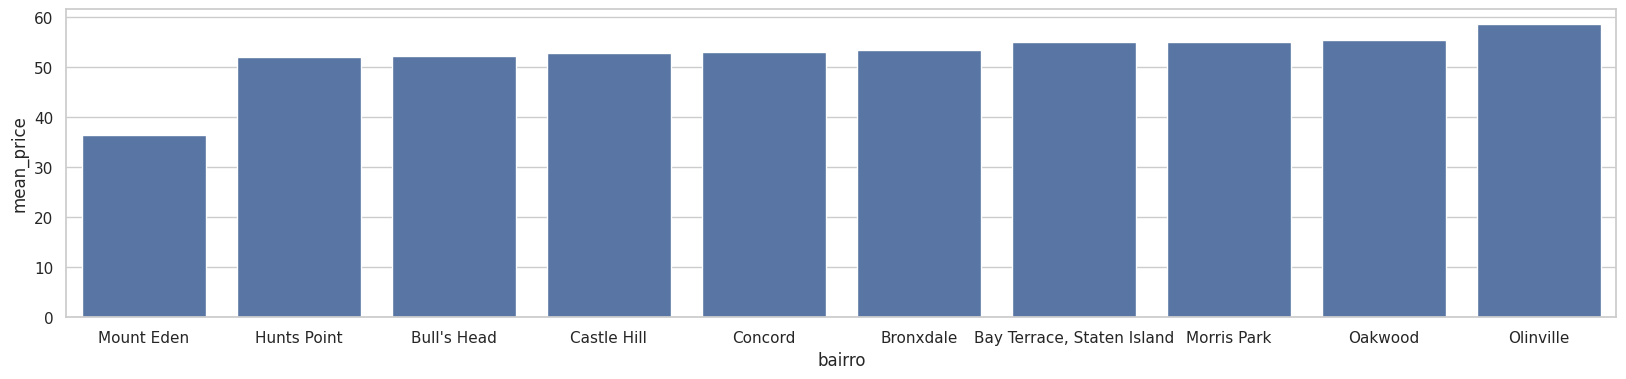

In [41]:
aux1=df4[['bairro','price']].groupby('bairro').mean().sort_values('price',ascending=True).rename(columns={'price':'mean_price'}).reset_index().head(10)
plt.figure(figsize=(20, 4))
sns.barplot(data=aux1,x='bairro',y='mean_price');

### **latitude/longitude**

In [42]:
# lats=df4['latitude']
# lons=df4['longitude']
# locations = list(zip(lats, lons))

# m = folium.Map(location=[np.mean(lats), np.mean(lons)], tiles="Cartodb Positron", zoom_start=1)
# marker_cluster = MarkerCluster(
#     locations=locations,
#     name="1000 clustered icons",
#     overlay=True,
#     control=True)

# marker_cluster.add_to(m)

# folium.LayerControl().add_to(m)

# m

# m.save('../img/map.html')

### **room_type**

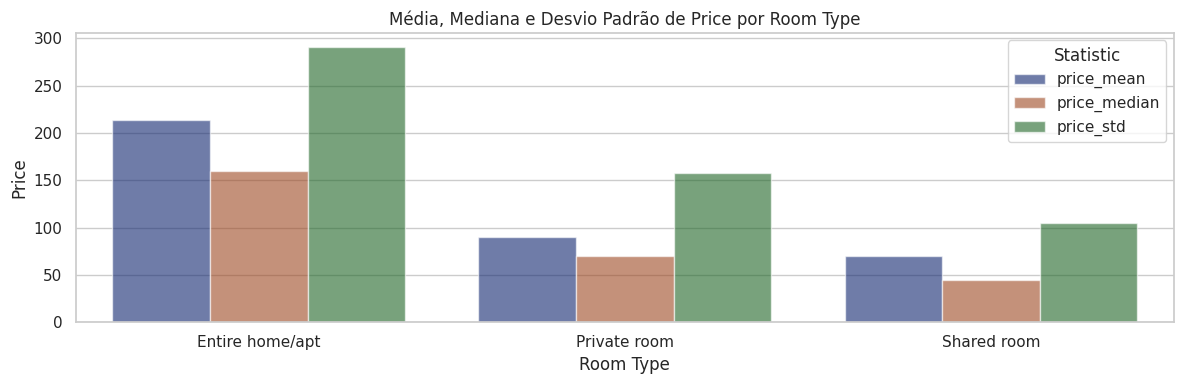

In [43]:
aux1 = df4[['room_type', 'price']].groupby('room_type').mean().sort_values('price', ascending=False).reset_index()
aux2 = df4[['room_type', 'price']].groupby('room_type').median().sort_values('price', ascending=False).reset_index()
aux3 = df4[['room_type', 'price']].groupby('room_type').std().sort_values('price', ascending=False).reset_index()

result1 = pd.merge(aux1, aux2, on='room_type', suffixes=('_mean', '_median'))
result2 = pd.merge(result1, aux3, on='room_type', suffixes=('', '_std'))
aux = result2.rename(columns={'price': 'price_std'})

viz = pd.melt(aux, id_vars=['room_type'], value_vars=['price_mean', 'price_median', 'price_std'],
              var_name='Statistic', value_name='Value')

plt.figure(figsize=(12, 4))
sns.barplot(
    data=viz, x="room_type", y="Value", hue="Statistic",
    errorbar="sd", palette="dark", alpha=.6)

plt.title('Média, Mediana e Desvio Padrão de Price por Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.legend(title='Statistic')

plt.tight_layout()

### **minimo_noites**

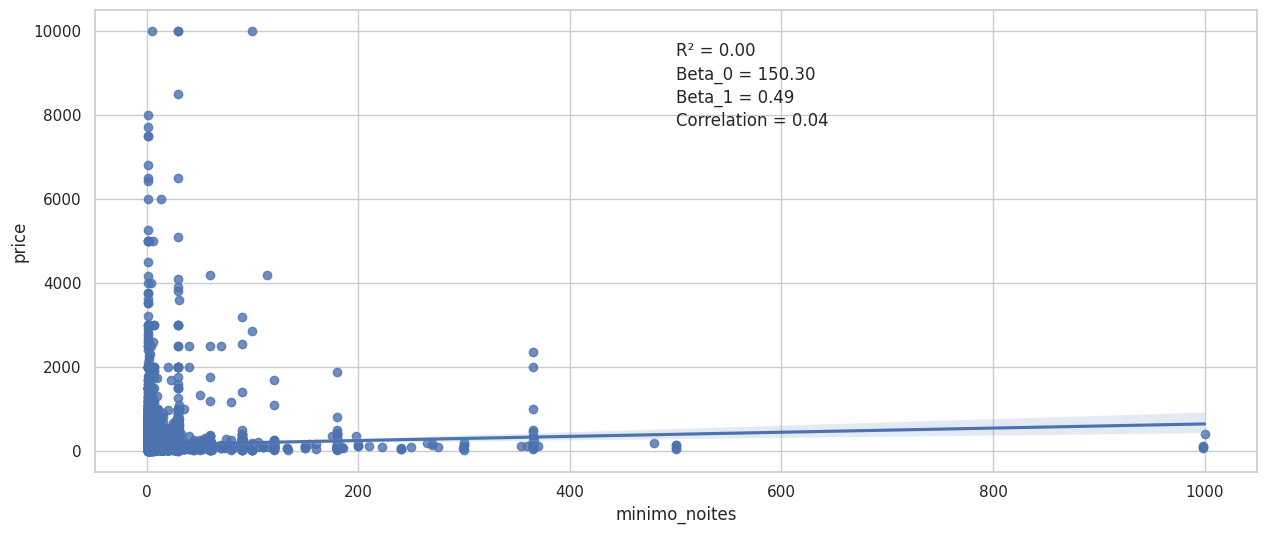

In [44]:
X = sm.add_constant(df4['minimo_noites'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['minimo_noites'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='minimo_noites', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='minimo_noites', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **numero_de_reviews**

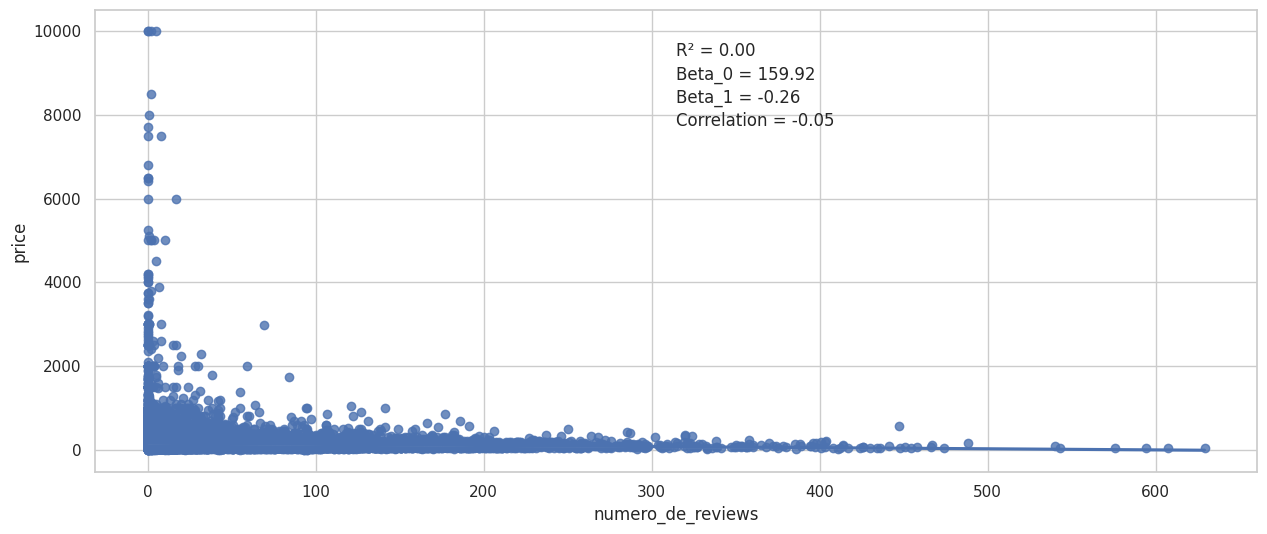

In [45]:
X = sm.add_constant(df4['numero_de_reviews'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['numero_de_reviews'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='numero_de_reviews', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='numero_de_reviews', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **ultima_review**

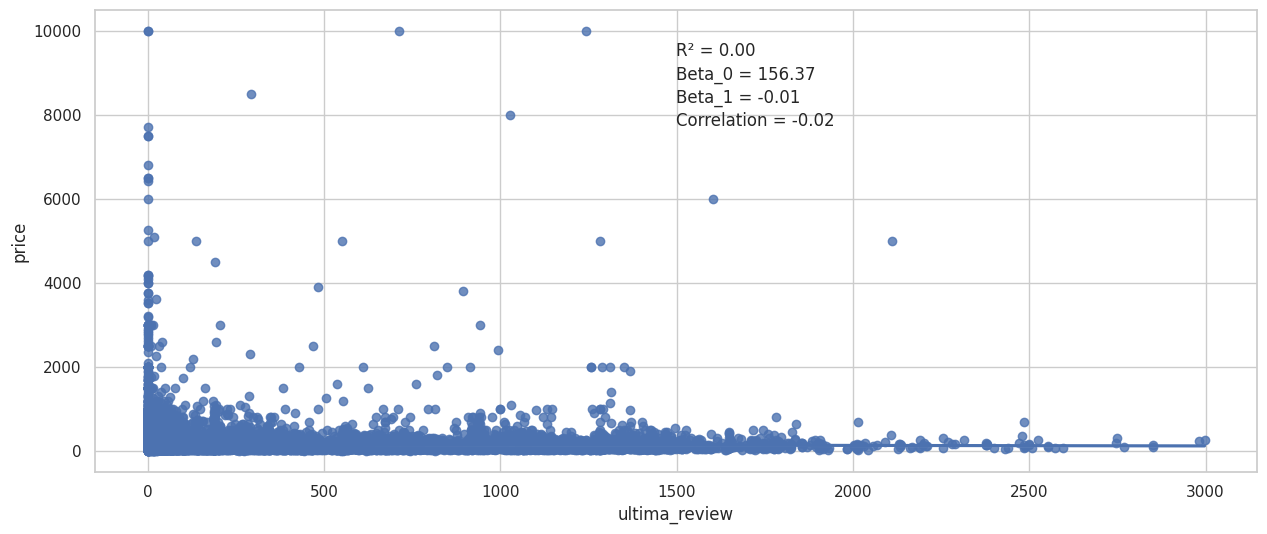

In [46]:
df4['ultima_review'] = df4['ultima_review'].fillna('2019-07-09')

ref_date = pd.to_datetime('2019-07-09')
df4['ultima_review'] = (df4['ultima_review'] - ref_date).dt.days
df4['ultima_review']=df4['ultima_review'] * -1

X = sm.add_constant(df4['ultima_review'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['ultima_review'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='ultima_review', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='ultima_review', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **reviews_por_mes**

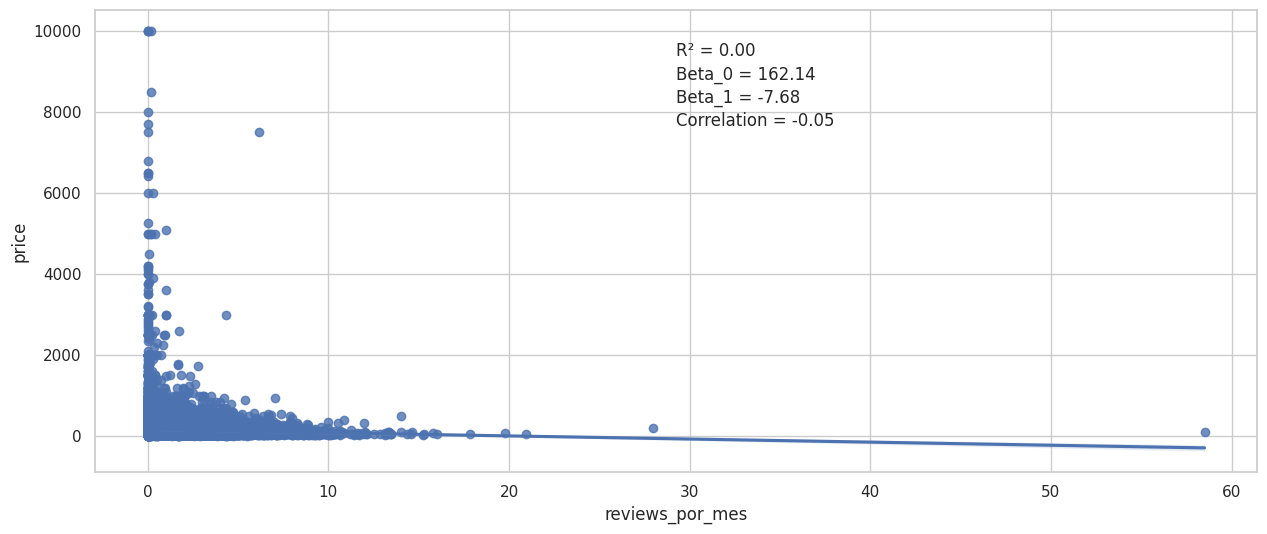

In [47]:
X = sm.add_constant(df4['reviews_por_mes'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['reviews_por_mes'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='reviews_por_mes', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='reviews_por_mes', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **calculado_host_listings_count**

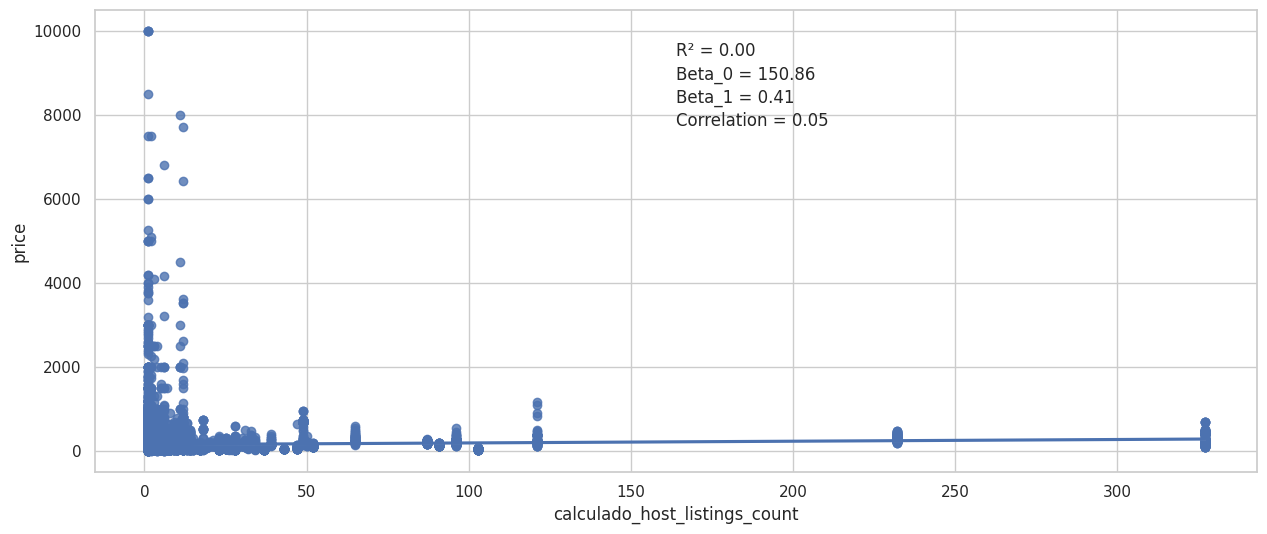

In [48]:
X = sm.add_constant(df4['calculado_host_listings_count'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['calculado_host_listings_count'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='calculado_host_listings_count', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='calculado_host_listings_count', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **disponibilidade_365**

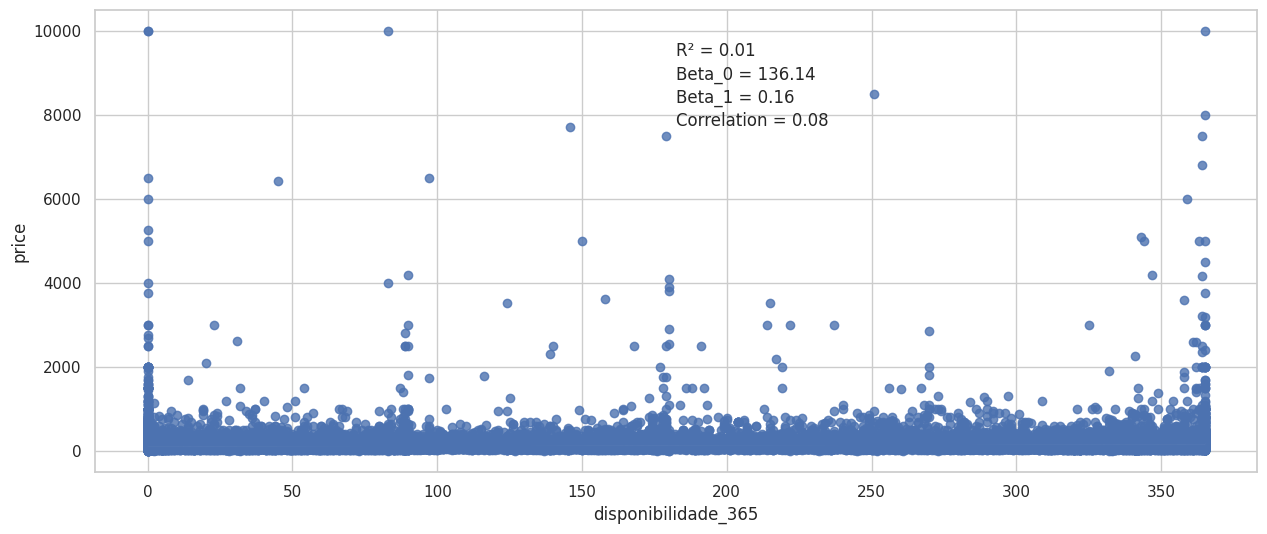

In [49]:
X = sm.add_constant(df4['disponibilidade_365'])
y = df4['price']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = df4['disponibilidade_365'].corr(df4['price'])

sns.set(style="whitegrid")
ax = sns.regplot(x='disponibilidade_365', y='price', data=df4)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='disponibilidade_365', ylabel='price')
plt.gcf().set_size_inches(15, 6)
plt.show()

## **4.4 Multivariate analysis**


### **4.4.1 Numerical attributes**

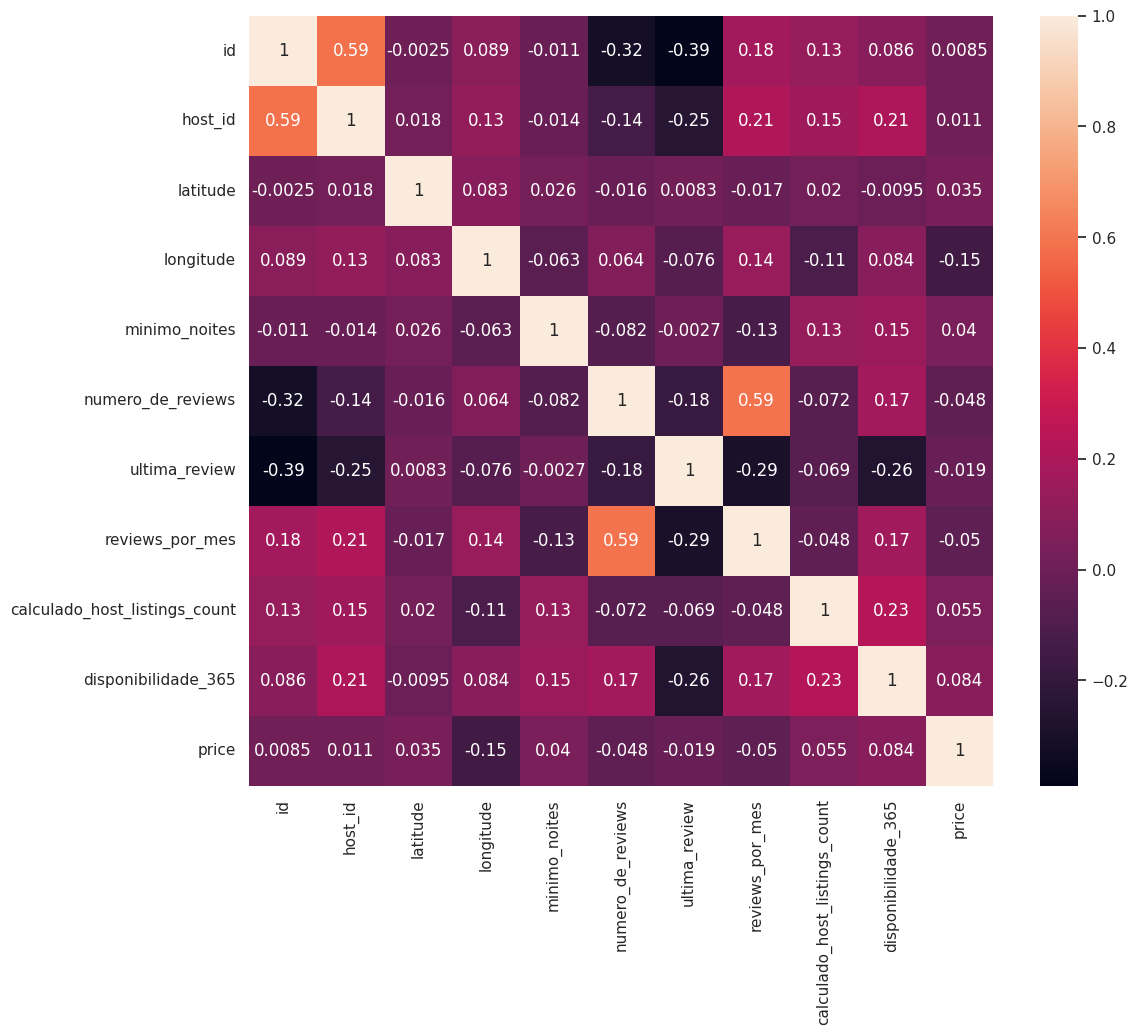

In [50]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

aux=df4[['host_id','id','price','minimo_noites','numero_de_reviews','ultima_review','reviews_por_mes','calculado_host_listings_count','disponibilidade_365']]
correlation=num_attributes.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(correlation,annot=True);
plt.show()

#### numero_de_reviews e id

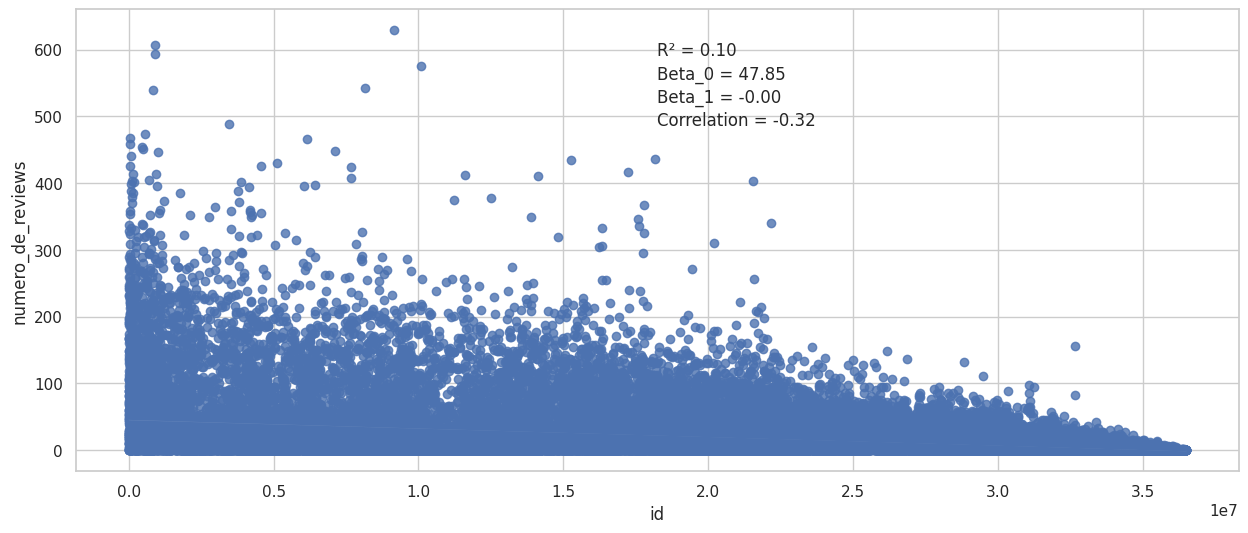

In [51]:
X = sm.add_constant(aux['id'])
y = aux['numero_de_reviews']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = aux['id'].corr(aux['numero_de_reviews'])

sns.set(style="whitegrid")
ax = sns.regplot(x='id', y='numero_de_reviews', data=aux)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='id', ylabel='numero_de_reviews')
plt.gcf().set_size_inches(15, 6)
plt.show()

#### minimo_noites e numero_de_reviews

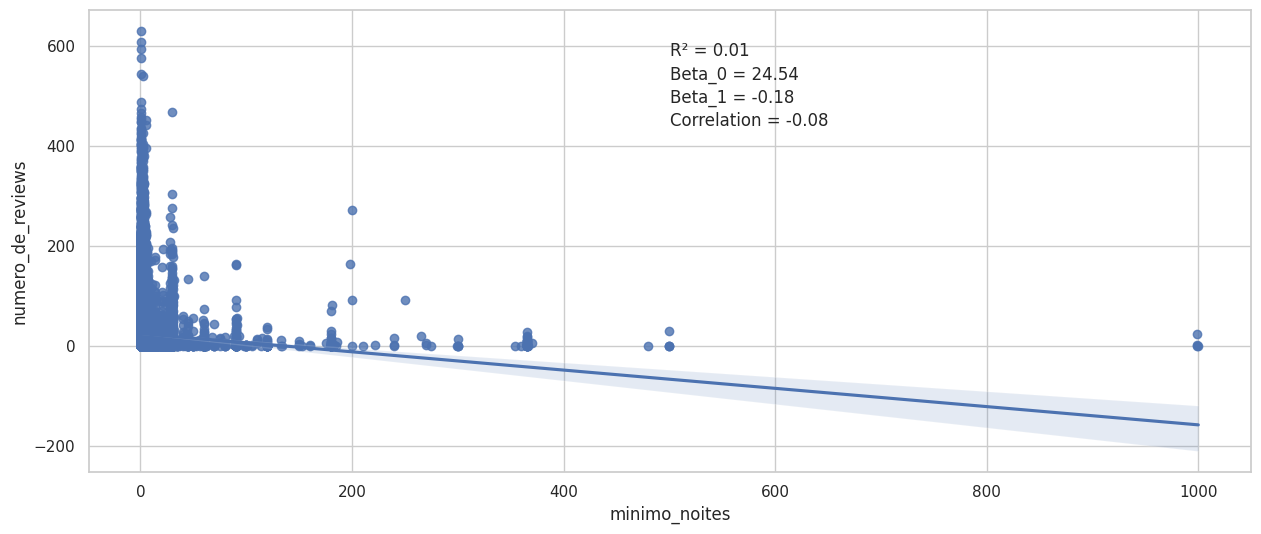

In [52]:
X = sm.add_constant(aux['minimo_noites'])
y = aux['numero_de_reviews']
model = sm.OLS(y, X).fit()

beta_0 = model.params[0]
beta_1 = model.params[1]

r_squared = model.rsquared

correlation = aux['minimo_noites'].corr(aux['numero_de_reviews'])

sns.set(style="whitegrid")
ax = sns.regplot(x='minimo_noites', y='numero_de_reviews', data=aux)

ax.annotate(f'R² = {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_0 = {beta_0:.2f}', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Beta_1 = {beta_1:.2f}', xy=(0.5, 0.80), xycoords='axes fraction', fontsize=12)
ax.annotate(f'Correlation = {correlation:.2f}', xy=(0.5, 0.75), xycoords='axes fraction', fontsize=12)

ax.set(xlabel='minimo_noites', ylabel='numero_de_reviews')
plt.gcf().set_size_inches(15, 6)
plt.show()

### **4.4.2 Categorical attributes**

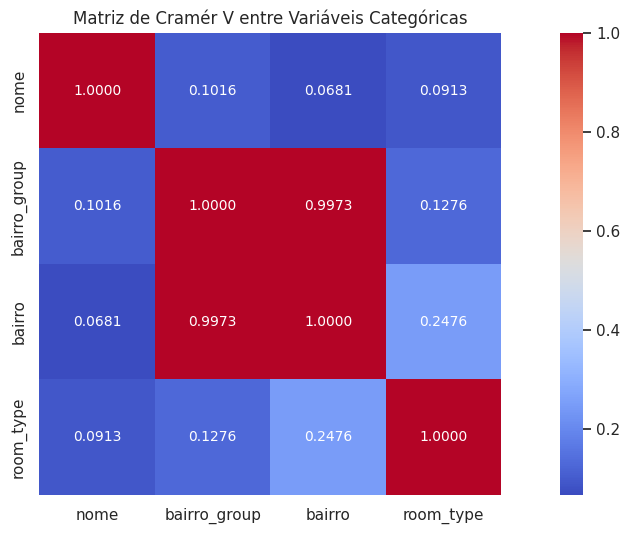

In [53]:
nome = df4['nome']
bairro_group = df4['bairro_group']
bairro = df4['bairro']
room_type = df4['room_type']

# Criar DataFrame para visualização
dataframe_for_heatmap = pd.DataFrame({
    'nome': nome,
    'bairro_group': bairro_group,
    'bairro': bairro,
    'room_type': room_type
})

# Calcular matriz de Cramér V
cramers_v_matrix = calculate_cramers_v_matrix(dataframe_for_heatmap)

# Criar heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.4f', annot_kws={'size': 10})
plt.title('Matriz de Cramér V entre Variáveis Categóricas')
plt.show()

## **4.5 Main insights**

- A variável resposta possui muitos outliers mas tem uma concentração muito alta em valores mais baixos, também possui 9 linhas com valor igual a zero.

- A chave única para cada anúncio e id do usuário provavelmente são geradas aleatoriamente.

- Alguns host names são repetidos trazendo uma média de preço para um nome específico; isso talvez até possibilitasse o uso de um target encoder, porém atrelar nomes de pessoas a valores de aluguel não faz muito sentido.

- Existe uma relação muito clara entre bairro_group e o preço (todos os imóveis estão em Nova York).

- O bairro está atrelado ao bairro_group, portanto é uma variável importante, porém devido a essa forte correlação talvez uma delas será excluída.

- Latitude e longitude podem se tornar importantes com algum tratamento, depois será necessário estudar se será inviabilizada devido a uma possível correlação com bairro_group/bairro.

- Existe uma relação muito clara entre room_type e o preço.

- Minimo_noites, numero_de_reviews, ultima_review, reviews_por_mes, calculado_host_listings_count e disponibilidade_365 não possuem uma correlação importante com o preço.

- Fora as correlações já citadas, não há outras importantes. 

# **5 Data preparation**

In [191]:
df5=df4.copy()
X_train=df5.drop(['price'],axis=1)
y_train=df5['price']
X_val=x_val.copy()
X_test=x_test.copy()

## **5.1 Histograms**

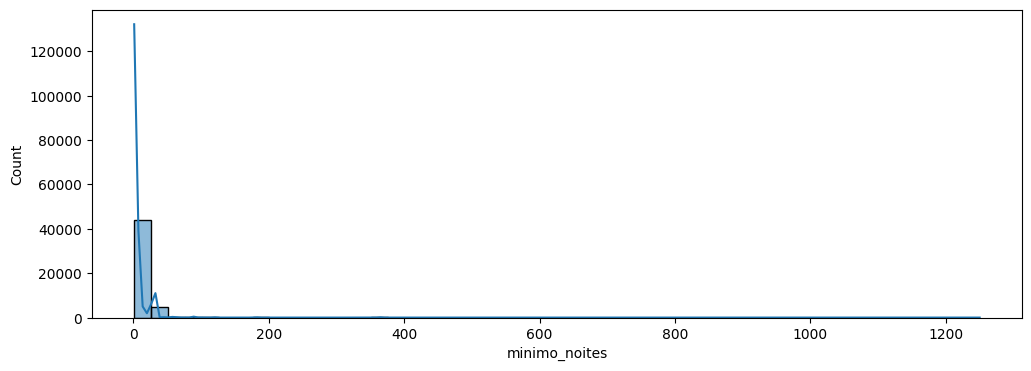

In [196]:
plt.figure(figsize=(12, 4))
sns.histplot(df1, x='minimo_noites',bins=50, kde=True)
plt.show()

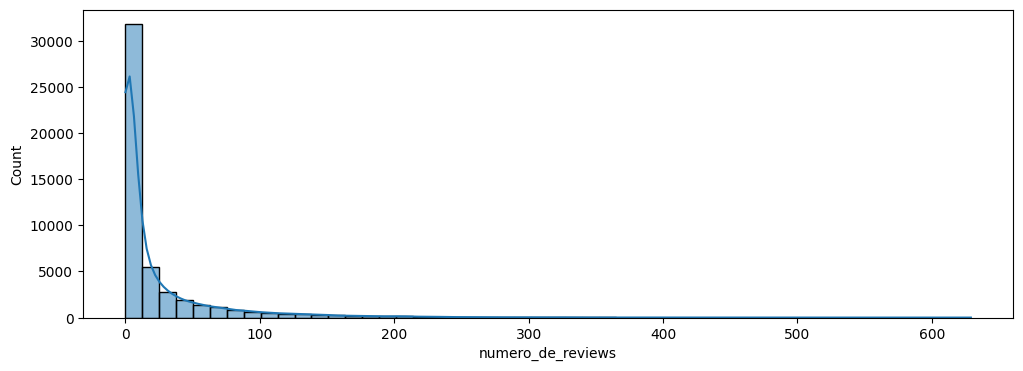

In [197]:
plt.figure(figsize=(12, 4))
sns.histplot(df1, x='numero_de_reviews',bins=50, kde=True)
plt.show()

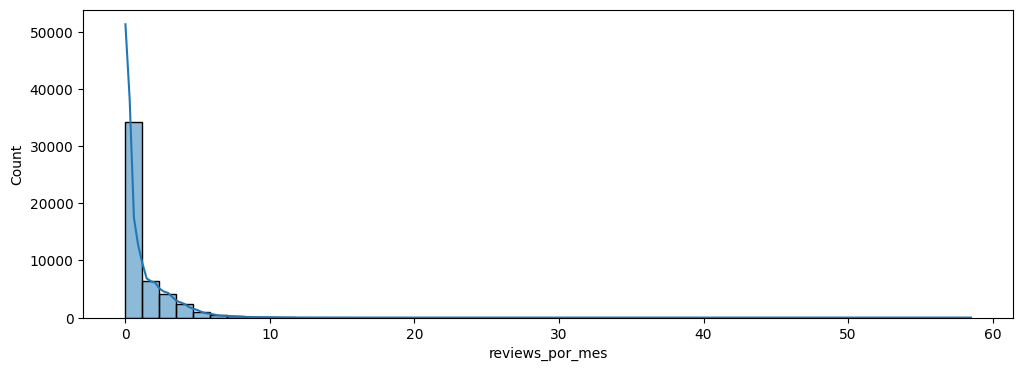

In [198]:
plt.figure(figsize=(12, 4))
sns.histplot(df1, x='reviews_por_mes',bins=50, kde=True)
plt.show()

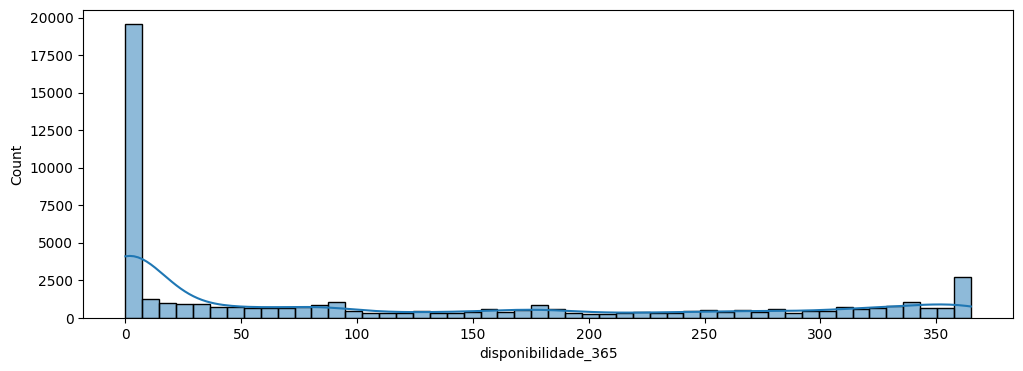

In [199]:
plt.figure(figsize=(12, 4))
sns.histplot(df1, x='disponibilidade_365',bins=50, kde=True)
plt.show()

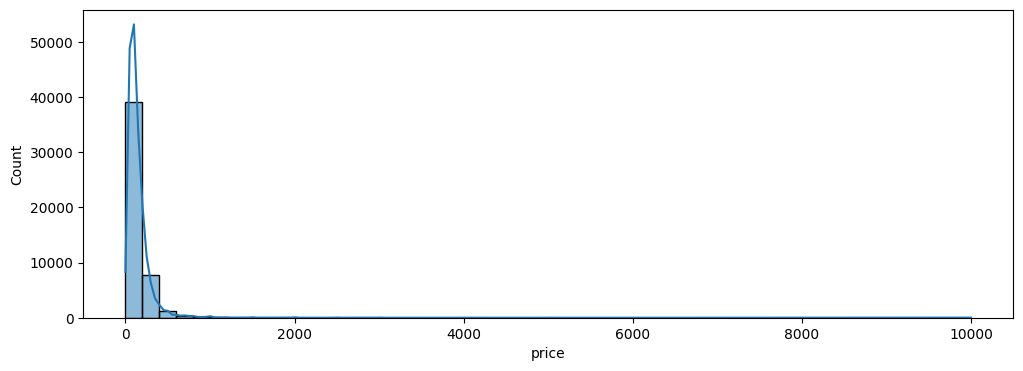

In [200]:
plt.figure(figsize=(12, 4))
sns.histplot(df1, x='price',bins=50, kde=True)
plt.show()

## **<s>5.2 Standardization<s/>**

## **5.3 Rescaling**

In [192]:
y_train=np.log1p(y_train) 
y_val=np.log1p(y_val)
y_test=np.log1p(y_test) 

## **5.4 Encoding**

In [193]:
# bairro_group
# X_train=pd.get_dummies(X_train,prefix=['bairro_group'],columns=['bairro_group'])
# X_val=pd.get_dummies(X_val,prefix=['bairro_group'],columns=['bairro_group'])
# X_test=pd.get_dummies(X_test,prefix=['bairro_group'],columns=['bairro_group'])

te = TargetEncoder(cols=['bairro_group'])
X_train = te.fit_transform(X_train, y_train)
# pickle.dump(te, open( '../parameters/target_bairro_group.pkl', 'wb') )
X_val = te.transform(X_val)
X_test = te.transform(X_test)

# bairro = {'Manhattan': 5, 'Brooklyn': 4, 'Staten Island': 3, 'Queens':2, 'Bronx':1 }
# X_train['bairro_group'] = X_train['bairro_group'].map(bairro)
# X_val['bairro_group'] = X_val['bairro_group'].map(bairro)
# X_test['bairro_group'] = X_test['bairro_group'].map(bairro)

# bairro
te = TargetEncoder(cols=['bairro'])
X_train = te.fit_transform(X_train, y_train)
# pickle.dump(te, open( '../parameters/target_bairro.pkl', 'wb') )
X_val = te.transform(X_val)
X_test = te.transform(X_test)

# room_type
# X_train=pd.get_dummies(X_train,prefix=['room_type'],columns=['room_type'])
# X_val=pd.get_dummies(X_val,prefix=['room_type'],columns=['room_type'])
# X_test=pd.get_dummies(X_test,prefix=['room_type'],columns=['room_type'])

te = TargetEncoder(cols=['room_type'])
X_train = te.fit_transform(X_train, y_train)
# pickle.dump(te, open( '../parameters/target_room_type.pkl', 'wb') )
X_val = te.transform(X_val)
X_test = te.transform(X_test)

# room = {'Shared room': 1, 'Private room': 2, 'Entire home/apt': 3}
# X_train['room_type'] = X_train['room_type'].map(room)
# X_val['room_type'] = X_val['room_type'].map(room)
# X_test['room_type'] = X_test['room_type'].map(room)

# category
te = TargetEncoder(cols=['category'])
X_train = te.fit_transform(X_train, y_train)
# pickle.dump(te, open( '../parameters/target_category.pkl', 'wb') )
X_val = te.transform(X_val)
X_test = te.transform(X_test)

In [1030]:
# print(X_train.isna().sum())
# print(X_val.isna().sum())
# print(X_test.isna().sum())

# **6 Feature selection**

In [89]:
df6=df5.copy()

In [ ]:
# forest=en.RandomForestClassifier(random_state=42,n_jobs=-1) 

# # data preparation
# x_train_n=X_train.drop(['id','host_id','price'],axis=1)
# y_train_n=y_train.values
# forest.fit(x_train_n,y_train_n)

# importances=forest.feature_importances_
# std=np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
# indices=np.argsort(importances)[::-1]  

# # print the feature ranking
# print('Feature ranking')
# df=pd.DataFrame()
# for i, j in zip(x_train_n,forest.feature_importances_): 
#     aux=pd.DataFrame({'feature':i,'importance':j},index=[0])
#     df=pd.concat([df,aux],axis=0)
    
# print(df.sort_values('importance',ascending=False))

In [152]:
X_train=X_train[['bairro', 'bairro_group','ultima_review',
       'minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count',
       'disponibilidade_365', 'latitude','longitude', 'category',
       'room_type']]

X_val=X_val[['bairro', 'bairro_group','ultima_review',
       'minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count',
       'disponibilidade_365', 'latitude','longitude', 'category',
       'room_type']]

X_test=X_test[['bairro', 'bairro_group','ultima_review',
       'minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count',
       'disponibilidade_365', 'latitude','longitude', 'category',
       'room_type']]

In [155]:
# para testar a conversão automática das variáveis categóricas no catboost

# cat_features=['bairro_group', 'bairro','room_type']

# X_train=X_train[['bairro_group', 'bairro',
#        'latitude', 'longitude', 'room_type', 'minimo_noites',
#        'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
#        'calculado_host_listings_count', 'disponibilidade_365']]

# X_val=X_val[['bairro_group', 'bairro',
#        'latitude', 'longitude', 'room_type', 'minimo_noites',
#        'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
#        'calculado_host_listings_count', 'disponibilidade_365']]

# X_test=X_test[['bairro_group', 'bairro',
#        'latitude', 'longitude', 'room_type', 'minimo_noites',
#        'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
#        'calculado_host_listings_count', 'disponibilidade_365']]

# **7 Machine Learning**

In [90]:
df7=df6.copy()

## **7.1 Average model**

In [91]:
y_train = df7['price']

y_mean = y_train.mean()

baseline_predictions = pd.Series([y_mean] * len(y_train))

mae_baseline = mean_absolute_error(y_train, baseline_predictions)
mape_baseline = mean_absolute_percentage_error(y_train, baseline_predictions)
mse_baseline = mean_squared_error(y_train, baseline_predictions)
rmse_baseline = np.sqrt(mse_baseline)

result_baseline = pd.DataFrame({'Model Name': 'Baseline model',
                       'MAE': mae_baseline,
                       'MAPE': mape_baseline,
                       'RMSE': rmse_baseline}, index=[0])
result_baseline

,Model Name,MAE,MAPE,RMSE
0,Baseline model,88.610938,0.872001,178.58916


## **7.2 Linear regression**

In [76]:
# model
lr=LinearRegression().fit(X_train,y_train)

# prediction
lr_yhat=lr.predict(X_val)

mae_lr = mean_absolute_error(np.expm1(y_val), np.expm1(lr_yhat))
mape_lr = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(lr_yhat))
mse_lr = mean_squared_error(np.expm1(y_val), np.expm1(lr_yhat))
rmse_lr = np.sqrt((mse_lr))

result_lr = pd.DataFrame({'Model Name': 'Linear Regression',
                       'MAE': mae_lr,
                       'MAPE': mape_lr,
                       'RMSE': rmse_lr}, index=[0])
result_lr

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,57.093053,0.339794,248.109865


### **7.2.1 Linear regression model - Cross validation** 

In [77]:
lr_cv = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(lr_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_lr_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_lr_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_lr_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_lr_cv)
std_mape = np.std(-mape_lr_cv)
std_rmse = np.std(-rmse_lr_cv)

result_lr_cv = pd.DataFrame({'Model Name': 'Linear Regression CV',
                              'MAE': mae_lr_cv,
                              'MAPE': mape_lr_cv,
                              'RMSE': rmse_lr_cv}, index=[0])

result_lr_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression CV,58.506377,0.351993,162.392385


## **7.3 Linear regression regularized**

In [78]:
# model
lrr=Lasso().fit(X_train,y_train)
 
# prediction
lrr_yhat=lrr.predict(X_val)

mae_lrr = mean_absolute_error(np.expm1(y_val), np.expm1(lrr_yhat))
mape_lrr = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(lrr_yhat))
mse_lrr = mean_squared_error(np.expm1(y_val), np.expm1(lrr_yhat))
rmse_lrr = np.sqrt(mse_lrr)

result_lrr = pd.DataFrame({'Model Name': 'Lasso',
                       'MAE': mae_lrr,
                       'MAPE': mape_lrr,
                       'RMSE': rmse_lrr}, index=[0])
result_lrr

,Model Name,MAE,MAPE,RMSE
0,Lasso,78.600065,0.586675,259.591137


### **7.3.1 Linear regression regularized - Cross validation**

In [79]:
lrr_cv = Lasso()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(lrr_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_lrr_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_lrr_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_lrr_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_lrr_cv)
std_mape = np.std(-mape_lrr_cv)
std_rmse = np.std(-rmse_lrr_cv)

result_lrr_cv = pd.DataFrame({'Model Name': 'Lasso CV',
                              'MAE': mae_lrr_cv,
                              'MAPE': mape_lrr_cv,
                              'RMSE': rmse_lrr_cv}, index=[0])

result_lrr_cv

,Model Name,MAE,MAPE,RMSE
0,Lasso CV,80.413548,0.606918,181.342764


## **7.4 Random Forest Regressor**

In [80]:
# model
rf=RandomForestRegressor(n_jobs=-1,random_state=95).fit(X_train,y_train)

# prediction
rf_yhat=rf.predict(X_val)

mae_rf = mean_absolute_error(np.expm1(y_val), np.expm1(rf_yhat))
mape_rf = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(rf_yhat))
mse_rf = mean_squared_error(np.expm1(y_val), np.expm1(rf_yhat))
rmse_rf = np.sqrt(mse_rf)

result_rf = pd.DataFrame({'Model Name': 'Random Forest',
                       'MAE': mae_rf,
                       'MAPE': mape_rf,
                       'RMSE': rmse_rf}, index=[0])
result_rf

,Model Name,MAE,MAPE,RMSE
0,Random Forest,53.573162,0.319534,243.905195


### **7.4.1 Random forest regressor - Cross validation** 

In [81]:
rf_cv=RandomForestRegressor(n_jobs=-1,random_state=95)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(rf_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_rf_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_rf_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_rf_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_rf_cv)
std_mape = np.std(-mape_rf_cv)
std_rmse = np.std(-rmse_rf_cv)

result_rf_cv = pd.DataFrame({'Model Name': 'Random Forest CV',
                              'MAE': mae_rf_cv,
                              'MAPE': mape_rf_cv,
                              'RMSE': rmse_rf_cv}, index=[0])

result_rf_cv

,Model Name,MAE,MAPE,RMSE
0,Random Forest CV,54.361176,0.329452,153.149289


## **7.5 XGBoost regressor**

In [82]:
xgb_model=XGBRegressor(n_jobs=-1,random_state=95).fit(X_train,y_train)

# prediction
xgb_yhat=xgb_model.predict(X_val)

mae_xgb = mean_absolute_error(np.expm1(y_val), np.expm1(xgb_yhat))
mape_xgb = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(xgb_yhat))
mse_xgb = mean_squared_error(np.expm1(y_val), np.expm1(xgb_yhat))
rmse_xgb = np.sqrt(mse_xgb)

result_xgb = pd.DataFrame({'Model Name': 'XGBoost',
                       'MAE': mae_xgb,
                       'MAPE': mape_xgb,
                       'RMSE': rmse_xgb}, index=[0])
result_xgb

,Model Name,MAE,MAPE,RMSE
0,XGBoost,53.161881,0.313124,244.25617


### **7.6 XGBoost regressor - Cross validation**

In [83]:
xgb_model_cv=XGBRegressor(n_jobs=-1,random_state=95)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(xgb_model_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_xgb_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_xgb_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_xgb_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_xgb_cv)
std_mape = np.std(-mape_xgb_cv)
std_rmse = np.std(-rmse_xgb_cv)

result_xgb_cv = pd.DataFrame({'Model Name': 'XGBoost CV',
                              'MAE': mae_xgb_cv,
                              'MAPE': mape_xgb_cv,
                              'RMSE': rmse_xgb_cv}, index=[0])

result_xgb_cv

,Model Name,MAE,MAPE,RMSE
0,XGBoost CV,53.982947,0.324878,152.752383


## **7.6 CatBoost regressor**

In [84]:
cat=CatBoostRegressor(logging_level='Silent').fit(X_train,y_train)

# prediction
cat_yhat=cat.predict(X_val)

mae_cat = mean_absolute_error(np.expm1(y_val), np.expm1(cat_yhat))
mape_cat = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(cat_yhat))
mse_cat = mean_squared_error(np.expm1(y_val), np.expm1(cat_yhat))
rmse_cat = np.sqrt(mse_cat)

result_cat = pd.DataFrame({'Model Name': 'CatBoost',
                       'MAE': mae_cat,
                       'MAPE': mape_cat,
                       'RMSE': rmse_cat}, index=[0])
result_cat

,Model Name,MAE,MAPE,RMSE
0,CatBoost,52.313421,0.304406,244.42243


In [85]:
# cat1=CatBoostRegressor(cat_features=cat_features, simple_ctr='Borders', combinations_ctr='Borders', logging_level='Silent').fit(X_train,y_train)
# cat2=CatBoostRegressor(cat_features=cat_features, simple_ctr='Buckets', combinations_ctr='Buckets', logging_level='Silent').fit(X_train,y_train)
# cat3=CatBoostRegressor(cat_features=cat_features, simple_ctr='BinarizedTargetMeanValue', combinations_ctr='BinarizedTargetMeanValue', logging_level='Silent').fit(X_train,y_train)
# cat4=CatBoostRegressor(cat_features=cat_features, simple_ctr='Counter', combinations_ctr='Counter', logging_level='Silent').fit(X_train,y_train)

# # prediction
# cat_yhat1=cat1.predict(X_val)
# cat_yhat2=cat2.predict(X_val)
# cat_yhat3=cat3.predict(X_val)
# cat_yhat4=cat4.predict(X_val)

# mae_cat1 = mean_absolute_error(np.expm1(y_val), np.expm1(cat_yhat1))
# mape_cat1 = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(cat_yhat1))
# mse_cat1= mean_squared_error(np.expm1(y_val), np.expm1(cat_yhat1))
# rmse_cat1 = np.sqrt(mse_cat1)

# mae_cat2 = mean_absolute_error(np.expm1(y_val), np.expm1(cat_yhat2))
# mape_cat2 = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(cat_yhat2))
# mse_cat2 = mean_squared_error(np.expm1(y_val), np.expm1(cat_yhat2))
# rmse_cat2 = np.sqrt(mse_cat2)

# mae_cat3 = mean_absolute_error(np.expm1(y_val), np.expm1(cat_yhat3))
# mape_cat3 = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(cat_yhat3))
# mse_cat3 = mean_squared_error(np.expm1(y_val), np.expm1(cat_yhat3))
# rmse_cat3 = np.sqrt(mse_cat3)

# mae_cat4 = mean_absolute_error(np.expm1(y_val), np.expm1(cat_yhat4))
# mape_cat4 = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(cat_yhat4))
# mse_cat4 = mean_squared_error(np.expm1(y_val), np.expm1(cat_yhat4))
# rmse_cat4 = np.sqrt(mse_cat4)


# result_cat1 = pd.DataFrame({'Model Name': 'CatBoost',
#                        'MAE': mae_cat1,
#                        'MAPE': mape_cat1,
#                        'RMSE': rmse_cat1}, index=[0])

# result_cat2 = pd.DataFrame({'Model Name': 'CatBoost',
#                        'MAE': mae_cat2,
#                        'MAPE': mape_cat2,
#                        'RMSE': rmse_cat2}, index=[0])

# result_cat3 = pd.DataFrame({'Model Name': 'CatBoost',
#                        'MAE': mae_cat3,
#                        'MAPE': mape_cat3,
#                        'RMSE': rmse_cat3}, index=[0])

# result_cat4 = pd.DataFrame({'Model Name': 'CatBoost',
#                        'MAE': mae_cat4,
#                        'MAPE': mape_cat4,
#                        'RMSE': rmse_cat4}, index=[0])
# print(result_cat1)
# print(result_cat2)
# print(result_cat3)
# print(result_cat4)

#   Model Name         MAE       MAPE        RMSE
# 0   CatBoost  126.166879  25.572822  146.405423
#   Model Name         MAE       MAPE        RMSE
# 0   CatBoost  126.236395  25.590634  146.408274
#   Model Name         MAE       MAPE        RMSE
# 0   CatBoost  126.166879  25.572822  146.405423
#   Model Name         MAE       MAPE        RMSE
# 0   CatBoost  126.219474  25.573147  147.196526

### **7.6.1 CatBoost regressor - Cross validation**

In [45]:
cat_cv=CatBoostRegressor(logging_level='Silent')

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(cat_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_cat_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_cat_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_cat_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_cat_cv)
std_mape = np.std(-mape_cat_cv)
std_rmse = np.std(-rmse_cat_cv)

result_cat_cv = pd.DataFrame({'Model Name': 'CatBoost CV',
                              'MAE': mae_cat_cv,
                              'MAPE': mape_cat_cv,
                              'RMSE': rmse_cat_cv}, index=[0])

result_cat_cv

,Model Name,MAE,MAPE,RMSE
0,CatBoost CV,53.207368,0.316628,152.662339


## **7.7 Compare performances**

In [92]:
modelling_result=pd.concat([result_baseline,result_lr,result_lrr,result_rf,result_xgb,result_cat])
modelling_result_cv=pd.concat([result_baseline,result_lr_cv,result_lrr_cv,result_rf_cv,result_xgb_cv,result_cat_cv])

modelling_result.sort_values('MAE',ascending=True)

,Model Name,MAE,MAPE,RMSE
0,CatBoost,52.313421,0.304406,244.422430
0,XGBoost,53.161881,0.313124,244.256170
0,Random Forest,53.573162,0.319534,243.905195
0,Linear Regression,57.093053,0.339794,248.109865
0,Lasso,78.600065,0.586675,259.591137
0,Baseline model,88.610938,0.872001,178.589160


## **7.8 Compare cross-validated performances**

In [93]:
modelling_result_cv.sort_values('MAE',ascending=True)

,Model Name,MAE,MAPE,RMSE
0,CatBoost CV,53.207368,0.316628,152.662339
0,XGBoost CV,53.982947,0.324878,152.752383
0,Random Forest CV,54.361176,0.329452,153.149289
0,Linear Regression CV,58.506377,0.351993,162.392385
0,Lasso CV,80.413548,0.606918,181.342764
0,Baseline model,88.610938,0.872001,178.589160


# **8 Hyperparameter fine-tuning**

In [496]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(trial):
    
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = CatBoostRegressor(**params, logging_level='Silent')

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    mae = mean_absolute_error(np.expm1(y_val), np.expm1(y_pred))

    return mae

# objeto de estudo Optuna
study = optuna.create_study(direction='minimize')

# executar a otimização 
study.optimize(objective, n_trials=100)

# melhores hiperparâmetros 
best_params = study.best_params

best_params

{'learning_rate': 0.059164179280409936,
 'depth': 10,
 'subsample': 0.8103544200203642,
 'colsample_bylevel': 0.6709284259791897,
 'min_data_in_leaf': 27}

## **8.1 Final model**

In [153]:
full_x = pd.concat ([X_train, X_val], axis=0,ignore_index=True) 
full_y = pd.concat ([y_train, y_val], axis=0,ignore_index=True) 

cat = CatBoostRegressor(**best_params,logging_level='Silent').fit(full_x,full_y)

# prediction
cat_yhat=cat.predict(X_test)

mae_cat = mean_absolute_error(np.expm1(y_test), np.expm1(cat_yhat))
mape_cat = mean_absolute_percentage_error_func(np.expm1(y_test), np.expm1(cat_yhat))
mse_cat = mean_squared_error(np.expm1(y_test), np.expm1(cat_yhat))
rmse_cat = np.sqrt(mse_cat)

final_result_cat = pd.DataFrame({'Model Name': 'CatBoost',
                       'MAE': mae_cat,
                       'MAPE': mape_cat,
                       'RMSE': rmse_cat}, index=[0])
final_result_cat

,Model Name,MAE,MAPE,RMSE
0,CatBoost,51.78667,0.30798,159.667159


## **8.2 Save model**

In [154]:
# pickle.dump(cat,open('../model/model_lighthouse.pkl','wb')) 

# **9 Error translation and interpretation**

In [158]:
df9=x_test.copy()
x_test['price']=np.expm1(y_test)
x_test['predictions']=np.expm1(cat_yhat)

## **9.1 Business performance**

In [159]:
# sum of predictions
df91=df9[['id','predictions','price']].groupby('id').sum().reset_index()             

# MAE and MAPE
df9_aux1=(df9[['id','price','predictions']].groupby('id')
          .apply(lambda x: mean_absolute_error (x['price'],x['predictions']))
          .reset_index().rename(columns={0:'MAE'}))

df9_aux2=(df9[['id','price','predictions']].groupby('id')
          .apply(lambda x: mean_absolute_percentage_error (x['price'],x['predictions']))
          .reset_index().rename(columns={0:'MAPE'}))

# merge
df9_aux3=pd.merge(df9_aux1,df9_aux2,how='inner',on='id')
df92=pd.merge(df91,df9_aux3,how='inner',on='id')

# scenarios
df92['worst_scenario']=df92['predictions'] - df92['MAE']
df92['best_scenario']=df92['predictions'] + df92['MAE']

# order columns
df92=df92[['id','price','predictions','worst_scenario','best_scenario','MAE','MAPE']]

df92['price']=df92['price'].map('${:,.2f}'.format)
df92['predictions']=df92['predictions'].map('${:,.2f}'.format)
df92['worst_scenario']=df92['worst_scenario'].map('${:,.2f}'.format)
df92['best_scenario']=df92['best_scenario'].map('${:,.2f}'.format)

In [160]:
# top 10 predictions
df92.sort_values('MAPE',ascending=True).head(10).reset_index(drop=True)

,id,price,predictions,worst_scenario,best_scenario,MAE,MAPE
0,15917981,$190.00,$190.00,$189.99,$190.00,0.003006,0.000016
1,873465,$115.00,$115.01,$115.00,$115.02,0.008928,0.000078
2,10008615,$125.00,$124.97,$124.94,$125.00,0.027619,0.000221
3,34946772,$65.00,$65.02,$65.00,$65.03,0.015321,0.000236
4,5327035,$51.00,$50.99,$50.97,$51.00,0.013900,0.000273
5,17908179,$130.00,$129.96,$129.91,$130.00,0.043485,0.000335
6,4440020,$229.00,$228.91,$228.83,$229.00,0.085811,0.000375
7,29338399,$129.00,$129.08,$129.00,$129.17,0.082855,0.000642
8,28313234,$70.00,$70.05,$70.00,$70.10,0.049250,0.000704
9,31039678,$120.00,$120.09,$120.00,$120.18,0.089454,0.000745


In [161]:
# top 10 worse predictions
df92.sort_values('MAPE',ascending=False).head(10).reset_index(drop=True)

,id,price,predictions,worst_scenario,best_scenario,MAE,MAPE
0,21304320,$0.00,$27.42,$0.00,$54.84,27.418561,1.234822e+17
1,25839759,$10.00,$128.74,$10.00,$247.49,118.744855,1.187449e+01
2,21981703,$12.00,$131.06,$12.00,$250.11,119.056949,9.921412e+00
3,36280646,$16.00,$124.10,$16.00,$232.20,108.098336,6.756146e+00
4,35612982,$12.00,$72.32,$12.00,$132.64,60.319440,5.026620e+00
5,35965985,$44.00,$257.73,$44.00,$471.46,213.730980,4.857522e+00
6,35642891,$10.00,$53.05,$10.00,$96.10,43.048689,4.304869e+00
7,22229244,$20.00,$91.56,$20.00,$163.12,71.559768,3.577988e+00
8,8668115,$50.00,$224.58,$50.00,$399.16,174.578210,3.491564e+00
9,21741106,$43.00,$167.79,$43.00,$292.58,124.788849,2.902066e+00


In [162]:
df92[['price','predictions','worst_scenario','best_scenario']] = (df92[['price','predictions','worst_scenario','best_scenario']]
                                                                    .replace('[\$,]', '', regex=True).astype(float))

aux1=df92[df92['price']<=100]
aux2=df92[(df92['price']>100) & (df92['price']<=300)]
aux3=df92[(df92['price']>300) & (df92['price']<=500)]
aux4=df92[df92['price']>=500]

print(f'MAE médio de aluguéis até $100 : {round(aux1["MAE"].mean(),2)}')
print(f'MAE médio de aluguéis entre $101 a $300 : {round(aux2["MAE"].mean(),2)}')
print(f'MAE médio de aluguéis entre $301 a $500 : {round(aux3["MAE"].mean(),2)}')
print(f'MAE médio de aluguéis acima de $500 : {round(aux4["MAE"].mean(),2)}')

MAE médio de aluguéis até $100 : 20.46
MAE médio de aluguéis entre $101 a $300 : 44.21
MAE médio de aluguéis entre $301 a $500 : 162.94
MAE médio de aluguéis acima de $500 : 644.49


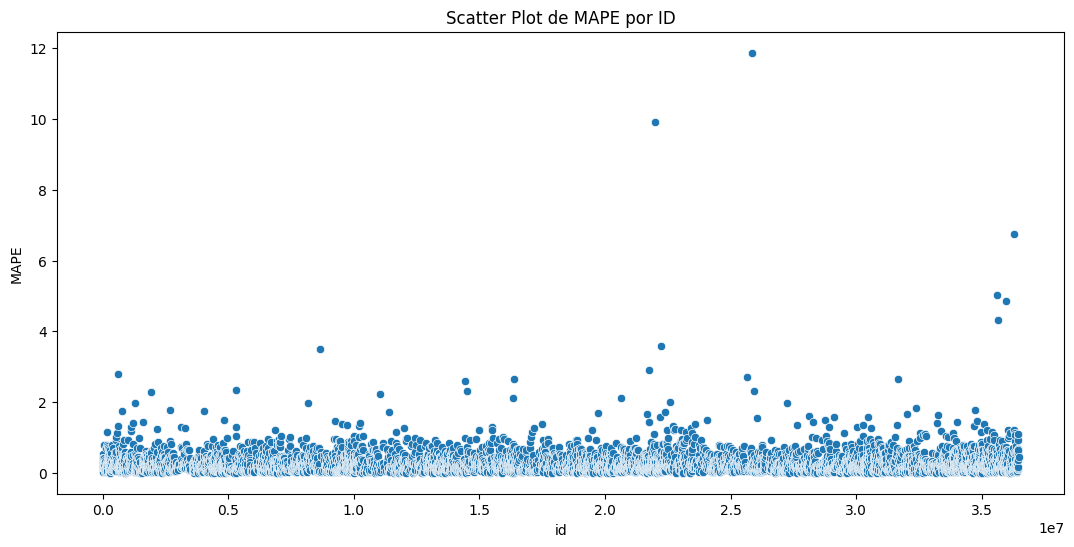

In [163]:
aux=df92.drop(df92[df92['id'] == 21304320].index, axis=0)

# px.scatter(aux,x='id',y='MAPE',height=500)

plt.figure(figsize=(13, 6))  
sns.scatterplot(x='id', y='MAPE', data=aux)
plt.title('Scatter Plot de MAPE por ID')
plt.show()

## **9.2 Total performance**

In [164]:
df93=(df92[['price','predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum (x),axis=0)
                                                                    .reset_index()
                                                                    .rename(columns={'index':'Scenario',0:'Values'}))
df93['Values']=df93['Values'].map('${:,.2f}'.format)
df93

,Scenario,Values
0,price,"$725,918.00"
1,predictions,"$632,748.18"
2,worst_scenario,"$379,511.14"
3,best_scenario,"$885,985.18"


## **9.3 Machine learning performance**

In [165]:
df9['error']=df9['price']-df9['predictions']

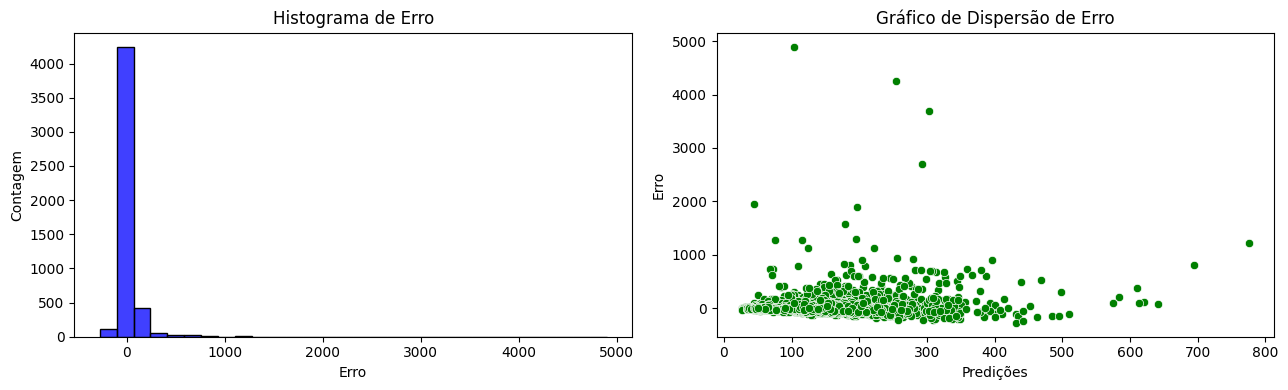

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

sns.histplot(df9['error'], bins=30, color='blue', ax=axs[0])
axs[0].set_title('Histograma de Erro')
axs[0].set_xlabel('Erro')
axs[0].set_ylabel('Contagem')

sns.scatterplot(x='predictions', y='error', data=df9, color='green', ax=axs[1])
axs[1].set_title('Gráfico de Dispersão de Erro')
axs[1].set_xlabel('Predições')
axs[1].set_ylabel('Erro')

plt.tight_layout()
plt.show()

# **10 Entregas**

## **1**

### a) Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e   
### apresentando algumas hipóteses de negócio relacionadas. Seja criativo!

A resposta está contida na seção 4 - Exploratory data analysis

## **2**

### a) Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, 
### onde seria mais indicada a compra?

Pensando na compra de um apartamento, seria no bairro_group Bronx, porque, segundo pesquisas, é o local mais acessível de Nova York    
para se comprar um apartamento, e tentando maximizar o lucro, um apartamento cujo preço de aluguel está acima do 2° quartil (maior que 50% dos preços).  

É necessário também escolher um apartamento cujo número de reviews esteja acima da média, o que sinaliza um local facilmente alugado.

Para aumentar a acurácia desse recomendação, seria necessário analisar os valores de compra dos apartamentos.

In [ ]:
# somente no Bronx e número de reviews superior à média geral
aux=df4[(df4['bairro_group']=='Bronx') & (df4['price']>106) & (df4['numero_de_reviews']>23)]

# filtrando apenas apartamentos
keywords = ['Apartment', 'apartment', 'Apt', 'apt']
filter = aux['nome'].str.contains('|'.join(keywords), case=False)
aux = aux[filter]

aux1=aux[['nome','bairro','room_type','price','numero_de_reviews']]
aux1.sort_values('price',ascending=False).head(10).reset_index(drop=True)

### b) O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Segundo os resultados já mencionados na EDA, não parece haver uma relação considerável entre o mínimo de noites e a disponibilidade com o preço

### c) Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Sim, existem algumas palavras que se repetem quando se filtra os imóveis com os maiores aluguéis.

Luxury - 5 vezes   
Beautiful - 4 vezes  
SuperBowl - 3 vezes   
Private - 3 vezes   
Townhouse - 3 vezes  
Film - 3 vezes 

**As palavras foram contadas com a ajuda de uma IA com base numa lista dos 50 imóveis com os maiores preços**   
(essas palavras não foram encontradas na lista dos 50 imóveis mais baratos, conforme análise da variável na Bivariate analysis)

## **3**

### Explique como você faria a previsão do preço a partir dos dados.    
### Quais variáveis e/ou suas transformações você utilizou e por quê?    
### Qual tipo de problema estamos resolvendo (regressão, classificação)?    
### Qual modelo melhor se aproxima dos dados e quais seus prós e contras?    
### Qual medida de performance do modelo foi escolhida e por quê?

- ### a) Quais variáveis e/ou suas transformações você utilizou e por quê?    

As variáveis criadas na feature engineering não foram úteis para o modelo, e das variáveis originais, optei por manter     
o menor número de variáveis possível, tentando manter o melhor desempenho, pensando num possível ambiente de produção, tornando o modelo    
menos complexo e mais robusto.    

Nas variáveis categóricas, eu usei onehot encoding para as de baixa cardinalidade (para melhor representar cada registro individualmente) e    
target encoding nas de alta cardinalidade (para evitar aumentar a dimensionalidade e considerar a relação com a variável resposta).    

Nas variáveis númerias, as técnicas de reescala não aumentaram a performance do modelo, então optei por não realizar essas transformações,   
exceto para a variável resposta, na qual usei np.log1 (para aproximar a distribuição de uma normal), aumentando a performance do modelo.    

- ### b) Qual tipo de problema estamos resolvendo (regressão, classificação)?    


O problema é de regressão, ou seja, prever um valor contínuo com base em sua relação com as variáveis independentes.   

- ### c) Qual modelo melhor se aproxima dos dados e quais seus prós e contras?    

O modelo que mais se aproximou dos dados foi o CatBoostRegressor.   

Prós: Rápido para treinar/tunar e gera um arquivo pkl leve, característica útil em produção.    

Contras: Difícil explicabilidade, no problema eu presumi que a performance seria mais importante que a explicabilidade,    
porém num cenário real pode acabar não sendo o caso se o problema de negócio envolver o contato com os donos dos imóveis ou possíveis clientes.   

- ### d) Qual medida de performance do modelo foi escolhida e por quê?

A métrica principal escolhida foi o MAE (erro médio absoluto).    

É fácil de interpretar e entender, facilita a compreensão do impacto no negócio e é robusto a outliers (importante característica nesse problema).    

## **4**

### Supondo um apartamento com as seguintes características:

{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',   
 'bairro_group': 'Manhattan',   
 'bairro': 'Midtown',   
 'latitude': 40.75362,   
 'longitude': -73.98377,   
 'room_type': 'Entire home/apt',   
 'price': 225,   
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',   
 'reviews_por_mes': 0.38,   
 'calculado_host_listings_count': 2,   
 'disponibilidade_365': 355}   

### Qual seria a sua sugestão de preço?

In [204]:
# previsão do modelo

model=pickle.load(open('../model/model_lighthouse.pkl','rb'))

target_bairro=pickle.load (open('../parameters/target_bairro.pkl','rb'))
target_category=pickle.load (open('../parameters/target_category.pkl','rb'))
target_room_type=pickle.load (open('../parameters/target_room_type.pkl','rb'))
target_bairro_group=pickle.load (open('../parameters/target_bairro_group.pkl','rb'))

x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test_split(df2, 
                                                        target = 'price', 
                                                        train_size=0.8, valid_size=0.1, test_size=0.1,
                                                        random_state=42)

dict = {'id': 2595,
             'nome': 'Skylit Midtown Castle',
             'host_id': 2845,
             'host_name': 'Jennifer',
             'bairro_group': 'Manhattan',
             'bairro': 'Midtown',
             'latitude': 40.75362,
             'longitude': -73.98377,
             'room_type': 'Entire home/apt',
             'minimo_noites': 1,
             'numero_de_reviews': 45,
             'ultima_review': '2019-05-21',
             'reviews_por_mes': 0.38,
             'calculado_host_listings_count': 2,
             'disponibilidade_365': 355}

df = pd.DataFrame([dict])

test = x_test.copy()
test = pd.concat([test, df], ignore_index=True)

# change types
test['ultima_review'] = pd.to_datetime(test['ultima_review'])

# nas
test['reviews_por_mes'] = np.where(test['reviews_por_mes'].isna(), 0, test['reviews_por_mes'])
cols = ['nome','host_name']
test[cols] = np.where(test[cols].isna(), 'desconhecido', test[cols])

test['category'] = test.apply(categorize_listing, axis=1)

test['ultima_review'] = test['ultima_review'].fillna('2019-07-09')
ref_date = pd.to_datetime('2019-07-09')
test['ultima_review'] = (test['ultima_review'] - ref_date).dt.days * -1

test=target_bairro.transform(test)
test=target_category.transform(test)
test=target_room_type.transform(test)
test=target_bairro_group.transform(test)

Test=test[['bairro', 'bairro_group','ultima_review',
       'minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count',
       'disponibilidade_365', 'latitude','longitude', 'category',
       'room_type']]

Test['id']=test['id']

pred = model.predict(Test)
Test['pred']=np.expm1(pred)

print(f'A previsão do modelo para o preço é: {Test.loc[Test["id"] == 2595, "pred"].values[0]}')

A previsão do modelo para o preço é: 311.89533710665614


In [205]:
# estatísticas de preço para o bairro group Manhattan
aux=df4[df4['bairro_group']=='Manhattan']
print(aux['price'].mean())
print(aux['price'].median())
print(aux['price'].std())

print('\n')
# estatísticas de preço para o bairro Midtown
aux=df4[df4['bairro']=='Midtown']
print(aux['price'].mean())
print(aux['price'].median())
print(aux['price'].std())

print('\n')
# estatísticas de preço para room type Entire home/apt
aux=df4[df4['room_type']=='Entire home/apt']
print(aux['price'].mean())
print(aux['price'].median())
print(aux['price'].std())

192.71440872560277
150.0
216.3390542221472


284.1510333863275
210.0
232.8775636869729


207.37749385749385
160.0
206.73386076855905


O preço original de 225 está de acordo com as médias para as suas principais características (bairro group,   
bairro e room type), mas poderia ser esticado um pouco mais, até 300-400 devido a média de aluguéis para o bairro Midtown ser de 287 e o   
desvio padrão ser alto (bem como nas demais características), e também se tratando de um imóvel com um alto número de reviews,     
provavelmente requisitado.   

Portanto, a previsão do modelo de $311 é realista, apesar de ser quase o dobro do preço original.